In [1]:
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import os, re, csv, string, random
import flair
# print(flair.__version__)


import nltk
from nltk.tokenize import RegexpTokenizer

from flair.data import Sentence, Span, Corpus, Dictionary, Token
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings, FlairEmbeddings, StackedEmbeddings, TokenEmbeddings
from flair.models import SequenceTagger

from flair.datasets import ColumnCorpus
from flair.trainers import ModelTrainer

from typing import List, Tuple

from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import pickle

from tqdm.auto import tqdm, trange

# import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
# from flair.data import Sentence

In [3]:
from google.colab import drive
drive.mount("/content/drive")

os.chdir('/content/drive/MyDrive/SI 630 project')
# os.listdir('.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
os.listdir('datasets/CADEC/CADEC.v2/cadec')


['sct',
 'text',
 'original - unedited version of edited files',
 'meddra - unedited version of edited files',
 'sct - unedited version of edited files',
 'original',
 'meddra']

In [5]:
suf = '_v3'

data_save_dir = 'data'+suf

In [6]:
meddra_counts = pd.read_csv(data_save_dir+'/meddra_counts.csv')
meddra_counts

,ner,meddra,counts_exploded,counts,counts_exploded_rank
0,Drug,Lipitor,1081,1073,1
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
...,...,...,...,...,...
1294,Finding,Senility,1,1,1233
1295,Drug,Seroquel,1,1,1233
1296,Drug,Solaraze,1,1,1233
1297,Drug,Tagamet,1,1,1233


In [7]:
meddra_counts.loc[meddra_counts.ner == 'ADR',:]

,ner,meddra,counts_exploded,counts,counts_exploded_rank
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
5,ADR,Arthralgia,280,163,6
...,...,...,...,...,...
1268,ADR,Labyrinthitis,1,1,1233
1269,ADR,Dysphagia,1,1,1233
1275,ADR,Lupus_erythematosus,1,1,1233
1278,ADR,Cataract,1,1,1233


In [8]:
with open(data_save_dir+'/cadec_flair_objects.pkl', 'rb') as f:
    docs = pickle.load(f)
docs[:10]

[Sentence[117]: "i feel a bit drowsy & have a little blurred vision , so far no gastric problems . ive been on arthrotec 50 for over 10 years on and off , only taking it when i needed it . due to my arthritis getting progressively worse , to the point where i am in tears with the agony , gp ' s started me on 75 twice a day and i have to take it . every day for the next month to see how i get on , here goes . so far its been very good , pains almost gone , but i feel a bit weird , didnt have that when on 50 ." → ["i"/O/O, "feel"/O/O, "a"/O/O, "bit"/B-ADR/B-Drowsy, "drowsy"/I-ADR/I-Drowsy, "&"/O/O, "have"/O/O, "a"/O/O, "little"/B-ADR/B-Blurred_vision_-_hazy, "blurred"/I-ADR/I-Blurred_vision_-_hazy, "vision"/I-ADR/I-Blurred_vision_-_hazy, ","/O/O, "so"/O/O, "far"/O/O, "no"/O/O, "gastric"/B-ADR/B-Excessive_upper_gastrointestinal_gas, "problems"/I-ADR/I-Excessive_upper_gastrointestinal_gas, "."/O/O, "ive"/O/O, "been"/O/O, "on"/O/O, "arthrotec"/B-Drug/B-Arthrotec, "50"/O/O, "for"/O/O, "over"

In [9]:
len(docs)

1186

In [10]:
temp = docs[0]
temp

Sentence[117]: "i feel a bit drowsy & have a little blurred vision , so far no gastric problems . ive been on arthrotec 50 for over 10 years on and off , only taking it when i needed it . due to my arthritis getting progressively worse , to the point where i am in tears with the agony , gp ' s started me on 75 twice a day and i have to take it . every day for the next month to see how i get on , here goes . so far its been very good , pains almost gone , but i feel a bit weird , didnt have that when on 50 ." → ["i"/O/O, "feel"/O/O, "a"/O/O, "bit"/B-ADR/B-Drowsy, "drowsy"/I-ADR/I-Drowsy, "&"/O/O, "have"/O/O, "a"/O/O, "little"/B-ADR/B-Blurred_vision_-_hazy, "blurred"/I-ADR/I-Blurred_vision_-_hazy, "vision"/I-ADR/I-Blurred_vision_-_hazy, ","/O/O, "so"/O/O, "far"/O/O, "no"/O/O, "gastric"/B-ADR/B-Excessive_upper_gastrointestinal_gas, "problems"/I-ADR/I-Excessive_upper_gastrointestinal_gas, "."/O/O, "ive"/O/O, "been"/O/O, "on"/O/O, "arthrotec"/B-Drug/B-Arthrotec, "50"/O/O, "for"/O/O, "over"/

In [11]:
temp.annotation_layers

{'ner': ['Token[0]: "i"'/'O' (1.0),
  'Token[1]: "feel"'/'O' (1.0),
  'Token[2]: "a"'/'O' (1.0),
  'Token[3]: "bit"'/'B-ADR' (1.0),
  'Token[4]: "drowsy"'/'I-ADR' (1.0),
  'Token[5]: "&"'/'O' (1.0),
  'Token[6]: "have"'/'O' (1.0),
  'Token[7]: "a"'/'O' (1.0),
  'Token[8]: "little"'/'B-ADR' (1.0),
  'Token[9]: "blurred"'/'I-ADR' (1.0),
  'Token[10]: "vision"'/'I-ADR' (1.0),
  'Token[11]: ","'/'O' (1.0),
  'Token[12]: "so"'/'O' (1.0),
  'Token[13]: "far"'/'O' (1.0),
  'Token[14]: "no"'/'O' (1.0),
  'Token[15]: "gastric"'/'B-ADR' (1.0),
  'Token[16]: "problems"'/'I-ADR' (1.0),
  'Token[17]: "."'/'O' (1.0),
  'Token[18]: "ive"'/'O' (1.0),
  'Token[19]: "been"'/'O' (1.0),
  'Token[20]: "on"'/'O' (1.0),
  'Token[21]: "arthrotec"'/'B-Drug' (1.0),
  'Token[22]: "50"'/'O' (1.0),
  'Token[23]: "for"'/'O' (1.0),
  'Token[24]: "over"'/'O' (1.0),
  'Token[25]: "10"'/'O' (1.0),
  'Token[26]: "years"'/'O' (1.0),
  'Token[27]: "on"'/'O' (1.0),
  'Token[28]: "and"'/'O' (1.0),
  'Token[29]: "off"'/'O' (

In [12]:

# define your NER tags
label_dict = {
    'ADR': 'ADR',
    'Drug': 'Drug',
    'Finding': 'Finding',
    'Symptom': 'Symptom',
    'Disease': 'Disease'
}

In [13]:
from flair.data import Corpus
# from flair.datasets import SentenceDataset
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings, TransformerWordEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
from torch.optim import AdamW, SGD

from flair.visual.training_curves import Plotter
plotter = Plotter()



train_docs, test_docs = train_test_split(docs, test_size=0.2, random_state=321)
dev_docs, test_docs = train_test_split(test_docs, test_size=0.5, random_state=123)

corpus = Corpus(train=train_docs, dev=dev_docs, test=test_docs) # Corpus: 948 train + 119 dev + 119 test sentences
corpus.filter_empty_sentences()
# # create a tag dictionary
labels = ['ADR', 'Drug', 'Finding', 'Symptom', 'Disease']
# tag_dictionary = Dictionary(add_unk=True)
# for label in labels:
#     tag_dictionary.add_item(label)
tag_dictionary = corpus.make_label_dictionary(label_type='ner')
print(tag_dictionary.span_labels)

# create a stacked embedding using GloVe and Flair embeddings
stacked_embeddings = StackedEmbeddings([
    WordEmbeddings('glove',
                   force_cpu=False,
                #    embedding_length=1024,
                  #  fine_tune=True,
                   ),
    # TransformerWordEmbeddings('emilyalsentzer/Bio_ClinicalBERT', layers="-1",
    #                                    subtoken_pooling="first",
    #                                    is_document_embedding=True,
    #                                    fine_tune=True,
    #                                    use_context=True,
    #                                    max_seq_length=1024,
    #                                    ),
    FlairEmbeddings('news-forward',
                    # fine_tune=True
                    ),
    FlairEmbeddings('news-backward',
                    # fine_tune=True
                    ),
])
# https://github.com/flairNLP/flair/blob/master/resources/docs/embeddings/FLAIR_EMBEDDINGS.md

# create a SequenceTagger object and specify the tag dictionary and embeddings to use
tagger = SequenceTagger(hidden_size=256,
                        embeddings=stacked_embeddings,
                        tag_dictionary=tag_dictionary,
                        tag_type='ner',
                        # use_crf=False,
                        # use_rnn=False,
                        # reproject_embeddings=False,
                        )
tagger.predict_spans = False

print(tagger._determine_if_span_prediction_problem(tagger.label_dictionary))
print(tagger.predict_spans)

# https://github.com/flairNLP/flair/blob/master/flair/trainers/trainer.py
# create a ModelTrainer object and train the tagger
trainer = ModelTrainer(tagger, corpus)

2023-04-21 01:37:10,223 Filtering empty sentences
2023-04-21 01:37:10,245 Corpus: 948 train + 119 dev + 119 test sentences
2023-04-21 01:37:10,246 Computing label dictionary. Progress:


948it [00:00, 7241.83it/s]

2023-04-21 01:37:10,382 Dictionary created for label 'ner' with 12 values: O (seen 79057 times), I-ADR (seen 7953 times), B-ADR (seen 4712 times), B-Drug (seen 1396 times), I-Finding (seen 349 times), B-Finding (seen 309 times), B-Disease (seen 231 times), B-Symptom (seen 222 times), I-Symptom (seen 218 times), I-Disease (seen 169 times), I-Drug (seen 161 times)
False


2023-04-21 01:37:18,974 SequenceTagger predicts: Dictionary with 12 tags: <unk>, O, I-ADR, B-ADR, B-Drug, I-Finding, B-Finding, B-Disease, B-Symptom, I-Symptom, I-Disease, I-Drug
True
False


In [14]:
# !tensorboard --logdir=runs
# http://localhost:6006/

In [15]:
hist = trainer.train('flair_ner_model'+suf,
              embeddings_storage_mode='gpu',
              gold_label_dictionary_for_eval=tag_dictionary,
              mini_batch_size = 12,
              eval_batch_size = 12,
              patience=1,
              anneal_factor = 0.5,
              anneal_against_dev_loss=True,
              main_evaluation_metric = ("weighted avg", "f1-score"),
              metrics_for_tensorboard=[("weighted avg", 'precision'), ("weighted avg", 'recall'), ("macro avg", 'f1-score'), ("macro avg", 'precision'), ("macro avg", 'recall')],
              use_tensorboard=True,
              tensorboard_comment='Flair NER',
              tensorboard_log_dir='runs/tb_logs'+suf,
              min_learning_rate=3e-8,
              optimizer=AdamW,
              learning_rate=1e-1,
              weight_decay=0.001,
              max_epochs=100,
              monitor_train=True,
              save_optimizer_state=True,)
# hist

2023-04-21 01:37:19,258 tensorboard logging path is runs/tb_logs_v3
2023-04-21 01:37:19,271 ----------------------------------------------------------------------------------------------------
2023-04-21 01:37:19,273 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4196, out_features=4196, bias=True)
  (rnn): LSTM(4196, 256, batch_first=True, bidirectional=True)
  (li

100%|██████████| 79/79 [00:21<00:00,  3.76it/s]

2023-04-21 01:38:13,805 Evaluating as a multi-label problem: True


2023-04-21 01:38:15,631 TRAIN : loss 1.1839491128921509 - f1-score (weighted avg)  0.1687


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


2023-04-21 01:38:21,761 Evaluating as a multi-label problem: False
2023-04-21 01:38:21,834 DEV : loss 1.2869369983673096 - f1-score (weighted avg)  0.1518
2023-04-21 01:38:21,843 BAD EPOCHS (no improvement): 0
2023-04-21 01:38:21,848 saving best model
2023-04-21 01:38:23,832 ----------------------------------------------------------------------------------------------------
2023-04-21 01:38:25,503 epoch 2 - iter 7/79 - loss 2.13743672 - time (sec): 1.67 - samples/sec: 5497.91 - lr: 0.100000
2023-04-21 01:38:27,062 epoch 2 - iter 14/79 - loss 2.02870205 - time (sec): 3.23 - samples/sec: 5183.89 - lr: 0.100000
2023-04-21 01:38:28,973 epoch 2 - iter 21/79 - loss 2.00009984 - time (sec): 5.14 - samples/sec: 5170.52 - lr: 0.100000
2023-04-21 01:38:30,573 epoch 2 - iter 28/79 - loss 2.00126866 - time (sec): 6.74 - samples/sec: 5199.88 - lr: 0.100000
2023-04-21 01:38:33,033 epoch 2 - iter 35/79 - loss 1.97140721 - time (sec): 9.20 - samples/sec: 4887.97 - lr: 0.100000
2023-04-21 01:38:34,604 

100%|██████████| 79/79 [00:20<00:00,  3.78it/s]

2023-04-21 01:39:04,268 Evaluating as a multi-label problem: True


2023-04-21 01:39:06,137 TRAIN : loss 1.327735424041748 - f1-score (weighted avg)  0.2611


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

2023-04-21 01:39:08,926 Evaluating as a multi-label problem: False
2023-04-21 01:39:08,998 DEV : loss 1.4661825895309448 - f1-score (weighted avg)  0.2539
2023-04-21 01:39:09,007 BAD EPOCHS (no improvement): 1
2023-04-21 01:39:09,011 ----------------------------------------------------------------------------------------------------


2023-04-21 01:39:10,531 epoch 3 - iter 7/79 - loss 2.09071951 - time (sec): 1.52 - samples/sec: 5272.60 - lr: 0.100000
2023-04-21 01:39:12,287 epoch 3 - iter 14/79 - loss 2.09841919 - time (sec): 3.27 - samples/sec: 5133.49 - lr: 0.100000
2023-04-21 01:39:13,766 epoch 3 - iter 21/79 - loss 2.14095172 - time (sec): 4.75 - samples/sec: 5324.79 - lr: 0.100000
2023-04-21 01:39:15,275 epoch 3 - iter 28/79 - loss 2.13310742 - time (sec): 6.26 - samples/sec: 5262.95 - lr: 0.100000
2023-04-21 01:39:16,704 epoch 3 - iter 35/79 - loss 2.18077149 - time (sec): 7.69 - samples/sec: 5297.89 - lr: 0.100000
2023-04-21 01:39:18,553 epoch 3 - iter 42/79 - loss 2.29270065 - time (sec): 9.54 - samples/sec: 5170.63 - lr: 0.100000
2023-04-21 01:39:20,339 epoch 3 - iter 49/79 - loss 2.44429083 - time (sec): 11.33 - samples/sec: 5195.21 - lr: 0.100000
2023-04-21 01:39:21,742 epoch 3 - iter 56/79 - loss 2.47920166 - time (sec): 12.73 - samples/sec: 5276.36 - lr: 0.100000
2023-04-21 01:39:23,519 epoch 3 - iter 

100%|██████████| 79/79 [00:22<00:00,  3.59it/s]

2023-04-21 01:39:50,092 Evaluating as a multi-label problem: True


2023-04-21 01:39:51,933 TRAIN : loss 1.302884578704834 - f1-score (weighted avg)  0.3157


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

2023-04-21 01:39:54,731 Evaluating as a multi-label problem: False
2023-04-21 01:39:54,798 DEV : loss 1.5197504758834839 - f1-score (weighted avg)  0.2753
2023-04-21 01:39:54,807 Epoch     3: reducing learning rate of group 0 to 5.0000e-02.
2023-04-21 01:39:54,809 BAD EPOCHS (no improvement): 2
2023-04-21 01:39:54,813 ----------------------------------------------------------------------------------------------------


2023-04-21 01:39:56,216 epoch 4 - iter 7/79 - loss 2.00701449 - time (sec): 1.40 - samples/sec: 5749.96 - lr: 0.050000
2023-04-21 01:39:58,579 epoch 4 - iter 14/79 - loss 1.98450738 - time (sec): 3.76 - samples/sec: 4675.26 - lr: 0.050000
2023-04-21 01:40:00,113 epoch 4 - iter 21/79 - loss 1.99451043 - time (sec): 5.30 - samples/sec: 4797.46 - lr: 0.050000
2023-04-21 01:40:01,434 epoch 4 - iter 28/79 - loss 2.02225075 - time (sec): 6.62 - samples/sec: 4975.47 - lr: 0.050000
2023-04-21 01:40:03,662 epoch 4 - iter 35/79 - loss 2.00361747 - time (sec): 8.85 - samples/sec: 4824.01 - lr: 0.050000
2023-04-21 01:40:05,065 epoch 4 - iter 42/79 - loss 2.01028992 - time (sec): 10.25 - samples/sec: 4886.85 - lr: 0.050000
2023-04-21 01:40:06,731 epoch 4 - iter 49/79 - loss 1.96485537 - time (sec): 11.92 - samples/sec: 4881.33 - lr: 0.050000
2023-04-21 01:40:08,285 epoch 4 - iter 56/79 - loss 1.95044891 - time (sec): 13.47 - samples/sec: 4945.58 - lr: 0.050000
2023-04-21 01:40:09,660 epoch 4 - iter

100%|██████████| 79/79 [00:20<00:00,  3.81it/s]

2023-04-21 01:40:34,408 Evaluating as a multi-label problem: True


2023-04-21 01:40:37,450 TRAIN : loss 2.172248363494873 - f1-score (weighted avg)  0.0238


100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

2023-04-21 01:40:40,182 Evaluating as a multi-label problem: False
2023-04-21 01:40:40,245 DEV : loss 2.1987593173980713 - f1-score (weighted avg)  0.0235
2023-04-21 01:40:40,254 BAD EPOCHS (no improvement): 1
2023-04-21 01:40:40,258 ----------------------------------------------------------------------------------------------------


2023-04-21 01:40:41,921 epoch 5 - iter 7/79 - loss 1.74158674 - time (sec): 1.66 - samples/sec: 5321.83 - lr: 0.050000
2023-04-21 01:40:43,314 epoch 5 - iter 14/79 - loss 1.62536348 - time (sec): 3.05 - samples/sec: 5309.78 - lr: 0.050000
2023-04-21 01:40:44,968 epoch 5 - iter 21/79 - loss 1.59076751 - time (sec): 4.71 - samples/sec: 5232.06 - lr: 0.050000
2023-04-21 01:40:46,580 epoch 5 - iter 28/79 - loss 1.53641090 - time (sec): 6.32 - samples/sec: 5192.73 - lr: 0.050000
2023-04-21 01:40:48,357 epoch 5 - iter 35/79 - loss 1.49184874 - time (sec): 8.10 - samples/sec: 5138.85 - lr: 0.050000
2023-04-21 01:40:49,987 epoch 5 - iter 42/79 - loss 1.44691499 - time (sec): 9.73 - samples/sec: 5044.21 - lr: 0.050000
2023-04-21 01:40:51,559 epoch 5 - iter 49/79 - loss 1.40414958 - time (sec): 11.30 - samples/sec: 5124.61 - lr: 0.050000
2023-04-21 01:40:53,111 epoch 5 - iter 56/79 - loss 1.39787420 - time (sec): 12.85 - samples/sec: 5088.64 - lr: 0.050000
2023-04-21 01:40:54,945 epoch 5 - iter 

100%|██████████| 79/79 [00:20<00:00,  3.81it/s]

2023-04-21 01:41:20,422 Evaluating as a multi-label problem: True


2023-04-21 01:41:22,297 TRAIN : loss 0.7297723293304443 - f1-score (weighted avg)  0.3955


100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

2023-04-21 01:41:25,049 Evaluating as a multi-label problem: False
2023-04-21 01:41:25,118 DEV : loss 0.8200908303260803 - f1-score (weighted avg)  0.3953
2023-04-21 01:41:25,127 BAD EPOCHS (no improvement): 0
2023-04-21 01:41:25,131 saving best model


2023-04-21 01:41:27,167 ----------------------------------------------------------------------------------------------------
2023-04-21 01:41:28,488 epoch 6 - iter 7/79 - loss 1.12853154 - time (sec): 1.30 - samples/sec: 4722.51 - lr: 0.050000
2023-04-21 01:41:30,363 epoch 6 - iter 14/79 - loss 1.29541220 - time (sec): 3.18 - samples/sec: 4821.16 - lr: 0.050000
2023-04-21 01:41:32,102 epoch 6 - iter 21/79 - loss 1.28745342 - time (sec): 4.92 - samples/sec: 4695.33 - lr: 0.050000
2023-04-21 01:41:33,695 epoch 6 - iter 28/79 - loss 1.21079876 - time (sec): 6.51 - samples/sec: 4886.46 - lr: 0.050000
2023-04-21 01:41:35,507 epoch 6 - iter 35/79 - loss 1.19112026 - time (sec): 8.32 - samples/sec: 4834.38 - lr: 0.050000
2023-04-21 01:41:37,115 epoch 6 - iter 42/79 - loss 1.20444361 - time (sec): 9.93 - samples/sec: 4925.56 - lr: 0.050000
2023-04-21 01:41:38,788 epoch 6 - iter 49/79 - loss 1.20488633 - time (sec): 11.60 - samples/sec: 4980.80 - lr: 0.050000
2023-04-21 01:41:40,412 epoch 6 - i

100%|██████████| 79/79 [00:22<00:00,  3.58it/s]

2023-04-21 01:42:08,543 Evaluating as a multi-label problem: True


2023-04-21 01:42:10,417 TRAIN : loss 0.7725613117218018 - f1-score (weighted avg)  0.3842


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

2023-04-21 01:42:13,255 Evaluating as a multi-label problem: False
2023-04-21 01:42:13,324 DEV : loss 0.8842422962188721 - f1-score (weighted avg)  0.3493
2023-04-21 01:42:13,334 BAD EPOCHS (no improvement): 1
2023-04-21 01:42:13,338 ----------------------------------------------------------------------------------------------------


2023-04-21 01:42:14,879 epoch 7 - iter 7/79 - loss 1.09679320 - time (sec): 1.54 - samples/sec: 4845.98 - lr: 0.050000
2023-04-21 01:42:16,403 epoch 7 - iter 14/79 - loss 1.19301123 - time (sec): 3.06 - samples/sec: 5034.83 - lr: 0.050000
2023-04-21 01:42:18,008 epoch 7 - iter 21/79 - loss 1.21019430 - time (sec): 4.67 - samples/sec: 5236.25 - lr: 0.050000
2023-04-21 01:42:19,722 epoch 7 - iter 28/79 - loss 1.17350594 - time (sec): 6.38 - samples/sec: 5225.01 - lr: 0.050000
2023-04-21 01:42:21,167 epoch 7 - iter 35/79 - loss 1.14885103 - time (sec): 7.83 - samples/sec: 5240.30 - lr: 0.050000
2023-04-21 01:42:23,179 epoch 7 - iter 42/79 - loss 1.07993376 - time (sec): 9.84 - samples/sec: 5161.63 - lr: 0.050000
2023-04-21 01:42:24,777 epoch 7 - iter 49/79 - loss 1.08012645 - time (sec): 11.44 - samples/sec: 5120.84 - lr: 0.050000
2023-04-21 01:42:27,127 epoch 7 - iter 56/79 - loss 1.13934082 - time (sec): 13.79 - samples/sec: 4959.30 - lr: 0.050000
2023-04-21 01:42:28,929 epoch 7 - iter 

100%|██████████| 79/79 [00:20<00:00,  3.81it/s]

2023-04-21 01:42:53,390 Evaluating as a multi-label problem: True


2023-04-21 01:42:56,541 TRAIN : loss 0.5955280661582947 - f1-score (weighted avg)  0.34


100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

2023-04-21 01:42:59,313 Evaluating as a multi-label problem: False
2023-04-21 01:42:59,378 DEV : loss 0.6364221572875977 - f1-score (weighted avg)  0.341
2023-04-21 01:42:59,387 BAD EPOCHS (no improvement): 0
2023-04-21 01:42:59,392 saving best model


2023-04-21 01:43:01,434 ----------------------------------------------------------------------------------------------------
2023-04-21 01:43:03,046 epoch 8 - iter 7/79 - loss 1.04688146 - time (sec): 1.60 - samples/sec: 4930.41 - lr: 0.050000
2023-04-21 01:43:04,533 epoch 8 - iter 14/79 - loss 1.26960268 - time (sec): 3.08 - samples/sec: 5278.31 - lr: 0.050000
2023-04-21 01:43:06,590 epoch 8 - iter 21/79 - loss 1.09637482 - time (sec): 5.14 - samples/sec: 4876.74 - lr: 0.050000
2023-04-21 01:43:08,309 epoch 8 - iter 28/79 - loss 1.11502789 - time (sec): 6.86 - samples/sec: 4879.48 - lr: 0.050000
2023-04-21 01:43:10,091 epoch 8 - iter 35/79 - loss 1.11636736 - time (sec): 8.64 - samples/sec: 4918.72 - lr: 0.050000
2023-04-21 01:43:12,140 epoch 8 - iter 42/79 - loss 1.12835904 - time (sec): 10.69 - samples/sec: 4728.46 - lr: 0.050000
2023-04-21 01:43:13,727 epoch 8 - iter 49/79 - loss 1.13577914 - time (sec): 12.28 - samples/sec: 4857.20 - lr: 0.050000
2023-04-21 01:43:15,595 epoch 8 - 

100%|██████████| 79/79 [00:20<00:00,  3.79it/s]

2023-04-21 01:43:42,191 Evaluating as a multi-label problem: True


2023-04-21 01:43:44,050 TRAIN : loss 0.8871518969535828 - f1-score (weighted avg)  0.3175


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

2023-04-21 01:43:46,852 Evaluating as a multi-label problem: False
2023-04-21 01:43:46,918 DEV : loss 0.9209219217300415 - f1-score (weighted avg)  0.3095
2023-04-21 01:43:46,927 BAD EPOCHS (no improvement): 1
2023-04-21 01:43:46,931 ----------------------------------------------------------------------------------------------------


2023-04-21 01:43:49,297 epoch 9 - iter 7/79 - loss 1.34722487 - time (sec): 2.36 - samples/sec: 3806.92 - lr: 0.050000
2023-04-21 01:43:51,182 epoch 9 - iter 14/79 - loss 1.32825387 - time (sec): 4.25 - samples/sec: 4358.68 - lr: 0.050000
2023-04-21 01:43:52,919 epoch 9 - iter 21/79 - loss 1.30399053 - time (sec): 5.99 - samples/sec: 4529.92 - lr: 0.050000
2023-04-21 01:43:54,295 epoch 9 - iter 28/79 - loss 1.29281987 - time (sec): 7.36 - samples/sec: 4731.14 - lr: 0.050000
2023-04-21 01:43:55,876 epoch 9 - iter 35/79 - loss 1.26301499 - time (sec): 8.94 - samples/sec: 4798.43 - lr: 0.050000
2023-04-21 01:43:57,578 epoch 9 - iter 42/79 - loss 1.25095876 - time (sec): 10.65 - samples/sec: 4791.66 - lr: 0.050000
2023-04-21 01:43:59,095 epoch 9 - iter 49/79 - loss 1.27914254 - time (sec): 12.16 - samples/sec: 4859.28 - lr: 0.050000
2023-04-21 01:44:00,443 epoch 9 - iter 56/79 - loss 1.27534274 - time (sec): 13.51 - samples/sec: 4863.50 - lr: 0.050000
2023-04-21 01:44:02,289 epoch 9 - iter

100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


2023-04-21 01:44:28,188 Evaluating as a multi-label problem: True
2023-04-21 01:44:30,052 TRAIN : loss 0.7888273596763611 - f1-score (weighted avg)  0.4317


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

2023-04-21 01:44:32,836 Evaluating as a multi-label problem: False
2023-04-21 01:44:32,904 DEV : loss 0.8150348663330078 - f1-score (weighted avg)  0.4373
2023-04-21 01:44:32,913 Epoch     9: reducing learning rate of group 0 to 2.5000e-02.
2023-04-21 01:44:32,915 BAD EPOCHS (no improvement): 2
2023-04-21 01:44:32,919 ----------------------------------------------------------------------------------------------------


2023-04-21 01:44:34,447 epoch 10 - iter 7/79 - loss 1.00874314 - time (sec): 1.53 - samples/sec: 4735.25 - lr: 0.025000
2023-04-21 01:44:35,996 epoch 10 - iter 14/79 - loss 1.19566850 - time (sec): 3.08 - samples/sec: 5416.29 - lr: 0.025000
2023-04-21 01:44:38,098 epoch 10 - iter 21/79 - loss 1.08719028 - time (sec): 5.18 - samples/sec: 5048.81 - lr: 0.025000
2023-04-21 01:44:39,605 epoch 10 - iter 28/79 - loss 1.04207998 - time (sec): 6.68 - samples/sec: 5098.76 - lr: 0.025000
2023-04-21 01:44:41,227 epoch 10 - iter 35/79 - loss 0.98736826 - time (sec): 8.31 - samples/sec: 5176.00 - lr: 0.025000
2023-04-21 01:44:42,808 epoch 10 - iter 42/79 - loss 0.96179264 - time (sec): 9.89 - samples/sec: 5198.01 - lr: 0.025000
2023-04-21 01:44:44,221 epoch 10 - iter 49/79 - loss 0.94177239 - time (sec): 11.30 - samples/sec: 5162.39 - lr: 0.025000
2023-04-21 01:44:45,961 epoch 10 - iter 56/79 - loss 0.91144397 - time (sec): 13.04 - samples/sec: 5168.57 - lr: 0.025000
2023-04-21 01:44:47,602 epoch 1

100%|██████████| 79/79 [00:20<00:00,  3.79it/s]

2023-04-21 01:45:12,918 Evaluating as a multi-label problem: True


2023-04-21 01:45:14,782 TRAIN : loss 0.4033581614494324 - f1-score (weighted avg)  0.4485


100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

2023-04-21 01:45:18,657 Evaluating as a multi-label problem: False
2023-04-21 01:45:18,726 DEV : loss 0.4373556971549988 - f1-score (weighted avg)  0.4447
2023-04-21 01:45:18,736 BAD EPOCHS (no improvement): 0
2023-04-21 01:45:18,741 saving best model


2023-04-21 01:45:20,838 ----------------------------------------------------------------------------------------------------
2023-04-21 01:45:22,575 epoch 11 - iter 7/79 - loss 0.81586174 - time (sec): 1.72 - samples/sec: 5222.88 - lr: 0.025000
2023-04-21 01:45:24,466 epoch 11 - iter 14/79 - loss 0.76079698 - time (sec): 3.61 - samples/sec: 4971.42 - lr: 0.025000
2023-04-21 01:45:25,896 epoch 11 - iter 21/79 - loss 0.71705342 - time (sec): 5.04 - samples/sec: 5132.16 - lr: 0.025000
2023-04-21 01:45:27,278 epoch 11 - iter 28/79 - loss 0.70299736 - time (sec): 6.43 - samples/sec: 5172.36 - lr: 0.025000
2023-04-21 01:45:28,963 epoch 11 - iter 35/79 - loss 0.70190839 - time (sec): 8.11 - samples/sec: 5142.10 - lr: 0.025000
2023-04-21 01:45:30,654 epoch 11 - iter 42/79 - loss 0.70023537 - time (sec): 9.80 - samples/sec: 5059.30 - lr: 0.025000
2023-04-21 01:45:32,931 epoch 11 - iter 49/79 - loss 0.68271823 - time (sec): 12.08 - samples/sec: 4993.05 - lr: 0.025000
2023-04-21 01:45:34,514 epoc

100%|██████████| 79/79 [00:20<00:00,  3.78it/s]

2023-04-21 01:46:00,872 Evaluating as a multi-label problem: True


2023-04-21 01:46:02,735 TRAIN : loss 0.7538142204284668 - f1-score (weighted avg)  0.232


100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

2023-04-21 01:46:05,488 Evaluating as a multi-label problem: False
2023-04-21 01:46:05,552 DEV : loss 0.7801929712295532 - f1-score (weighted avg)  0.2502
2023-04-21 01:46:05,562 BAD EPOCHS (no improvement): 1
2023-04-21 01:46:05,566 ----------------------------------------------------------------------------------------------------


2023-04-21 01:46:07,077 epoch 12 - iter 7/79 - loss 0.57966360 - time (sec): 1.51 - samples/sec: 4871.70 - lr: 0.025000
2023-04-21 01:46:08,982 epoch 12 - iter 14/79 - loss 0.62095039 - time (sec): 3.41 - samples/sec: 4684.19 - lr: 0.025000
2023-04-21 01:46:10,535 epoch 12 - iter 21/79 - loss 0.65637063 - time (sec): 4.97 - samples/sec: 4902.08 - lr: 0.025000
2023-04-21 01:46:12,149 epoch 12 - iter 28/79 - loss 0.64280812 - time (sec): 6.58 - samples/sec: 5012.96 - lr: 0.025000
2023-04-21 01:46:13,810 epoch 12 - iter 35/79 - loss 0.62648607 - time (sec): 8.24 - samples/sec: 5036.06 - lr: 0.025000
2023-04-21 01:46:15,475 epoch 12 - iter 42/79 - loss 0.61971169 - time (sec): 9.91 - samples/sec: 5006.68 - lr: 0.025000
2023-04-21 01:46:17,237 epoch 12 - iter 49/79 - loss 0.62822327 - time (sec): 11.67 - samples/sec: 4989.00 - lr: 0.025000
2023-04-21 01:46:18,826 epoch 12 - iter 56/79 - loss 0.62532612 - time (sec): 13.26 - samples/sec: 5022.57 - lr: 0.025000
2023-04-21 01:46:20,401 epoch 1

100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


2023-04-21 01:46:47,172 Evaluating as a multi-label problem: True
2023-04-21 01:46:49,053 TRAIN : loss 0.34727904200553894 - f1-score (weighted avg)  0.4685


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

2023-04-21 01:46:51,839 Evaluating as a multi-label problem: False
2023-04-21 01:46:51,908 DEV : loss 0.3659929931163788 - f1-score (weighted avg)  0.4668
2023-04-21 01:46:51,918 BAD EPOCHS (no improvement): 0
2023-04-21 01:46:51,922 saving best model


2023-04-21 01:46:53,982 ----------------------------------------------------------------------------------------------------
2023-04-21 01:46:55,571 epoch 13 - iter 7/79 - loss 0.60741808 - time (sec): 1.57 - samples/sec: 4907.30 - lr: 0.025000
2023-04-21 01:46:57,284 epoch 13 - iter 14/79 - loss 0.63899731 - time (sec): 3.28 - samples/sec: 4850.89 - lr: 0.025000
2023-04-21 01:46:58,782 epoch 13 - iter 21/79 - loss 0.65684823 - time (sec): 4.78 - samples/sec: 4881.82 - lr: 0.025000
2023-04-21 01:47:00,134 epoch 13 - iter 28/79 - loss 0.66804038 - time (sec): 6.13 - samples/sec: 5103.06 - lr: 0.025000
2023-04-21 01:47:02,308 epoch 13 - iter 35/79 - loss 0.64775881 - time (sec): 8.31 - samples/sec: 4917.08 - lr: 0.025000
2023-04-21 01:47:04,282 epoch 13 - iter 42/79 - loss 0.63860640 - time (sec): 10.28 - samples/sec: 4778.09 - lr: 0.025000
2023-04-21 01:47:06,421 epoch 13 - iter 49/79 - loss 0.61267448 - time (sec): 12.42 - samples/sec: 4753.36 - lr: 0.025000
2023-04-21 01:47:08,012 epo

100%|██████████| 79/79 [00:20<00:00,  3.78it/s]

2023-04-21 01:47:35,279 Evaluating as a multi-label problem: True


2023-04-21 01:47:37,145 TRAIN : loss 0.42664870619773865 - f1-score (weighted avg)  0.3502


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

2023-04-21 01:47:39,923 Evaluating as a multi-label problem: False
2023-04-21 01:47:39,990 DEV : loss 0.44500139355659485 - f1-score (weighted avg)  0.3588
2023-04-21 01:47:39,999 BAD EPOCHS (no improvement): 1
2023-04-21 01:47:40,003 ----------------------------------------------------------------------------------------------------


2023-04-21 01:47:42,048 epoch 14 - iter 7/79 - loss 0.52917847 - time (sec): 2.04 - samples/sec: 4126.56 - lr: 0.025000
2023-04-21 01:47:43,933 epoch 14 - iter 14/79 - loss 0.50263401 - time (sec): 3.93 - samples/sec: 4620.29 - lr: 0.025000
2023-04-21 01:47:45,322 epoch 14 - iter 21/79 - loss 0.50919435 - time (sec): 5.32 - samples/sec: 4804.33 - lr: 0.025000
2023-04-21 01:47:47,481 epoch 14 - iter 28/79 - loss 0.51235749 - time (sec): 7.48 - samples/sec: 4673.82 - lr: 0.025000
2023-04-21 01:47:49,032 epoch 14 - iter 35/79 - loss 0.53648228 - time (sec): 9.03 - samples/sec: 4833.39 - lr: 0.025000
2023-04-21 01:47:50,638 epoch 14 - iter 42/79 - loss 0.52839970 - time (sec): 10.63 - samples/sec: 4839.72 - lr: 0.025000
2023-04-21 01:47:52,274 epoch 14 - iter 49/79 - loss 0.53563987 - time (sec): 12.27 - samples/sec: 4858.42 - lr: 0.025000
2023-04-21 01:47:53,995 epoch 14 - iter 56/79 - loss 0.54892239 - time (sec): 13.99 - samples/sec: 4882.60 - lr: 0.025000
2023-04-21 01:47:55,422 epoch 

100%|██████████| 79/79 [00:22<00:00,  3.59it/s]

2023-04-21 01:48:21,347 Evaluating as a multi-label problem: True


2023-04-21 01:48:23,185 TRAIN : loss 0.40511006116867065 - f1-score (weighted avg)  0.3373


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

2023-04-21 01:48:25,974 Evaluating as a multi-label problem: False
2023-04-21 01:48:26,040 DEV : loss 0.42538926005363464 - f1-score (weighted avg)  0.331
2023-04-21 01:48:26,049 Epoch    14: reducing learning rate of group 0 to 1.2500e-02.
2023-04-21 01:48:26,051 BAD EPOCHS (no improvement): 2
2023-04-21 01:48:26,055 ----------------------------------------------------------------------------------------------------


2023-04-21 01:48:27,500 epoch 15 - iter 7/79 - loss 0.51349054 - time (sec): 1.44 - samples/sec: 5787.09 - lr: 0.012500
2023-04-21 01:48:28,880 epoch 15 - iter 14/79 - loss 0.52858358 - time (sec): 2.82 - samples/sec: 5499.03 - lr: 0.012500
2023-04-21 01:48:30,702 epoch 15 - iter 21/79 - loss 0.51079150 - time (sec): 4.65 - samples/sec: 5238.67 - lr: 0.012500
2023-04-21 01:48:32,833 epoch 15 - iter 28/79 - loss 0.49908941 - time (sec): 6.78 - samples/sec: 4949.81 - lr: 0.012500
2023-04-21 01:48:34,493 epoch 15 - iter 35/79 - loss 0.49765849 - time (sec): 8.44 - samples/sec: 4977.96 - lr: 0.012500
2023-04-21 01:48:36,320 epoch 15 - iter 42/79 - loss 0.48784877 - time (sec): 10.26 - samples/sec: 4979.58 - lr: 0.012500
2023-04-21 01:48:38,326 epoch 15 - iter 49/79 - loss 0.47315690 - time (sec): 12.27 - samples/sec: 4871.73 - lr: 0.012500
2023-04-21 01:48:39,969 epoch 15 - iter 56/79 - loss 0.47103139 - time (sec): 13.91 - samples/sec: 4918.68 - lr: 0.012500
2023-04-21 01:48:41,683 epoch 

100%|██████████| 79/79 [00:20<00:00,  3.77it/s]

2023-04-21 01:49:06,264 Evaluating as a multi-label problem: True


2023-04-21 01:49:09,366 TRAIN : loss 0.303382009267807 - f1-score (weighted avg)  0.4161


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]

2023-04-21 01:49:12,131 Evaluating as a multi-label problem: False
2023-04-21 01:49:12,197 DEV : loss 0.32187744975090027 - f1-score (weighted avg)  0.4164
2023-04-21 01:49:12,206 BAD EPOCHS (no improvement): 0
2023-04-21 01:49:12,210 saving best model


2023-04-21 01:49:14,281 ----------------------------------------------------------------------------------------------------
2023-04-21 01:49:15,868 epoch 16 - iter 7/79 - loss 0.41275606 - time (sec): 1.59 - samples/sec: 4621.44 - lr: 0.012500
2023-04-21 01:49:17,498 epoch 16 - iter 14/79 - loss 0.45583709 - time (sec): 3.22 - samples/sec: 4731.65 - lr: 0.012500
2023-04-21 01:49:19,173 epoch 16 - iter 21/79 - loss 0.45930663 - time (sec): 4.89 - samples/sec: 4867.25 - lr: 0.012500
2023-04-21 01:49:20,596 epoch 16 - iter 28/79 - loss 0.45994042 - time (sec): 6.31 - samples/sec: 5012.60 - lr: 0.012500
2023-04-21 01:49:22,221 epoch 16 - iter 35/79 - loss 0.44874746 - time (sec): 7.94 - samples/sec: 5023.75 - lr: 0.012500
2023-04-21 01:49:24,036 epoch 16 - iter 42/79 - loss 0.43667874 - time (sec): 9.75 - samples/sec: 4904.94 - lr: 0.012500
2023-04-21 01:49:25,763 epoch 16 - iter 49/79 - loss 0.42535907 - time (sec): 11.48 - samples/sec: 4934.98 - lr: 0.012500
2023-04-21 01:49:27,412 epoc

100%|██████████| 79/79 [00:20<00:00,  3.78it/s]

2023-04-21 01:49:55,155 Evaluating as a multi-label problem: True


2023-04-21 01:49:57,006 TRAIN : loss 0.2967628538608551 - f1-score (weighted avg)  0.4712


100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

2023-04-21 01:49:59,750 Evaluating as a multi-label problem: False
2023-04-21 01:49:59,817 DEV : loss 0.32144951820373535 - f1-score (weighted avg)  0.4601
2023-04-21 01:49:59,827 BAD EPOCHS (no improvement): 0
2023-04-21 01:49:59,830 saving best model


2023-04-21 01:50:01,888 ----------------------------------------------------------------------------------------------------
2023-04-21 01:50:03,797 epoch 17 - iter 7/79 - loss 0.43225755 - time (sec): 1.91 - samples/sec: 4041.94 - lr: 0.012500
2023-04-21 01:50:05,290 epoch 17 - iter 14/79 - loss 0.43091269 - time (sec): 3.40 - samples/sec: 4702.97 - lr: 0.012500
2023-04-21 01:50:06,953 epoch 17 - iter 21/79 - loss 0.41792999 - time (sec): 5.06 - samples/sec: 4746.85 - lr: 0.012500
2023-04-21 01:50:08,639 epoch 17 - iter 28/79 - loss 0.40304070 - time (sec): 6.75 - samples/sec: 4756.24 - lr: 0.012500
2023-04-21 01:50:10,324 epoch 17 - iter 35/79 - loss 0.41718872 - time (sec): 8.43 - samples/sec: 4854.63 - lr: 0.012500
2023-04-21 01:50:12,548 epoch 17 - iter 42/79 - loss 0.41659678 - time (sec): 10.66 - samples/sec: 4662.95 - lr: 0.012500
2023-04-21 01:50:14,543 epoch 17 - iter 49/79 - loss 0.41819379 - time (sec): 12.65 - samples/sec: 4667.04 - lr: 0.012500
2023-04-21 01:50:16,001 epo

100%|██████████| 79/79 [00:21<00:00,  3.59it/s]

2023-04-21 01:50:43,789 Evaluating as a multi-label problem: True


2023-04-21 01:50:45,637 TRAIN : loss 0.38044536113739014 - f1-score (weighted avg)  0.2936


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

2023-04-21 01:50:48,428 Evaluating as a multi-label problem: False
2023-04-21 01:50:48,496 DEV : loss 0.3848266303539276 - f1-score (weighted avg)  0.3075
2023-04-21 01:50:48,506 BAD EPOCHS (no improvement): 1
2023-04-21 01:50:48,510 ----------------------------------------------------------------------------------------------------


2023-04-21 01:50:50,062 epoch 18 - iter 7/79 - loss 0.38913970 - time (sec): 1.55 - samples/sec: 5324.34 - lr: 0.012500
2023-04-21 01:50:51,876 epoch 18 - iter 14/79 - loss 0.39806269 - time (sec): 3.36 - samples/sec: 5078.70 - lr: 0.012500
2023-04-21 01:50:53,222 epoch 18 - iter 21/79 - loss 0.39344039 - time (sec): 4.71 - samples/sec: 5373.70 - lr: 0.012500
2023-04-21 01:50:54,653 epoch 18 - iter 28/79 - loss 0.39590140 - time (sec): 6.14 - samples/sec: 5284.48 - lr: 0.012500
2023-04-21 01:50:56,388 epoch 18 - iter 35/79 - loss 0.39873433 - time (sec): 7.88 - samples/sec: 5262.23 - lr: 0.012500
2023-04-21 01:50:57,838 epoch 18 - iter 42/79 - loss 0.40018047 - time (sec): 9.33 - samples/sec: 5220.52 - lr: 0.012500
2023-04-21 01:50:59,481 epoch 18 - iter 49/79 - loss 0.40444213 - time (sec): 10.97 - samples/sec: 5246.50 - lr: 0.012500
2023-04-21 01:51:01,211 epoch 18 - iter 56/79 - loss 0.40373242 - time (sec): 12.70 - samples/sec: 5211.02 - lr: 0.012500
2023-04-21 01:51:03,216 epoch 1

100%|██████████| 79/79 [00:20<00:00,  3.78it/s]

2023-04-21 01:51:28,067 Evaluating as a multi-label problem: True


2023-04-21 01:51:31,177 TRAIN : loss 0.30326125025749207 - f1-score (weighted avg)  0.4285


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]

2023-04-21 01:51:33,945 Evaluating as a multi-label problem: False
2023-04-21 01:51:34,012 DEV : loss 0.3335133492946625 - f1-score (weighted avg)  0.4069
2023-04-21 01:51:34,022 Epoch    18: reducing learning rate of group 0 to 6.2500e-03.
2023-04-21 01:51:34,024 BAD EPOCHS (no improvement): 2
2023-04-21 01:51:34,028 ----------------------------------------------------------------------------------------------------


2023-04-21 01:51:35,751 epoch 19 - iter 7/79 - loss 0.37609787 - time (sec): 1.72 - samples/sec: 4755.65 - lr: 0.006250
2023-04-21 01:51:37,309 epoch 19 - iter 14/79 - loss 0.38780583 - time (sec): 3.28 - samples/sec: 5170.69 - lr: 0.006250
2023-04-21 01:51:38,978 epoch 19 - iter 21/79 - loss 0.39796333 - time (sec): 4.95 - samples/sec: 5188.08 - lr: 0.006250
2023-04-21 01:51:40,795 epoch 19 - iter 28/79 - loss 0.39989234 - time (sec): 6.77 - samples/sec: 5066.37 - lr: 0.006250
2023-04-21 01:51:42,689 epoch 19 - iter 35/79 - loss 0.39179723 - time (sec): 8.66 - samples/sec: 4956.51 - lr: 0.006250
2023-04-21 01:51:44,343 epoch 19 - iter 42/79 - loss 0.38749874 - time (sec): 10.31 - samples/sec: 5021.17 - lr: 0.006250
2023-04-21 01:51:46,007 epoch 19 - iter 49/79 - loss 0.38286790 - time (sec): 11.98 - samples/sec: 4988.75 - lr: 0.006250
2023-04-21 01:51:47,461 epoch 19 - iter 56/79 - loss 0.38447870 - time (sec): 13.43 - samples/sec: 5016.86 - lr: 0.006250
2023-04-21 01:51:48,877 epoch 

100%|██████████| 79/79 [00:20<00:00,  3.77it/s]

2023-04-21 01:52:14,164 Evaluating as a multi-label problem: True


2023-04-21 01:52:16,014 TRAIN : loss 0.27803313732147217 - f1-score (weighted avg)  0.3833


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]

2023-04-21 01:52:18,773 Evaluating as a multi-label problem: False
2023-04-21 01:52:18,843 DEV : loss 0.2901894450187683 - f1-score (weighted avg)  0.3939
2023-04-21 01:52:18,852 BAD EPOCHS (no improvement): 0
2023-04-21 01:52:18,856 saving best model


2023-04-21 01:52:20,935 ----------------------------------------------------------------------------------------------------
2023-04-21 01:52:22,700 epoch 20 - iter 7/79 - loss 0.38479138 - time (sec): 1.76 - samples/sec: 4948.30 - lr: 0.006250
2023-04-21 01:52:24,536 epoch 20 - iter 14/79 - loss 0.35818226 - time (sec): 3.60 - samples/sec: 5010.85 - lr: 0.006250
2023-04-21 01:52:26,149 epoch 20 - iter 21/79 - loss 0.35166173 - time (sec): 5.21 - samples/sec: 5102.14 - lr: 0.006250
2023-04-21 01:52:27,841 epoch 20 - iter 28/79 - loss 0.34899261 - time (sec): 6.90 - samples/sec: 5067.83 - lr: 0.006250
2023-04-21 01:52:29,326 epoch 20 - iter 35/79 - loss 0.34840855 - time (sec): 8.39 - samples/sec: 5111.71 - lr: 0.006250
2023-04-21 01:52:30,843 epoch 20 - iter 42/79 - loss 0.35268393 - time (sec): 9.91 - samples/sec: 5106.94 - lr: 0.006250
2023-04-21 01:52:32,670 epoch 20 - iter 49/79 - loss 0.35316280 - time (sec): 11.73 - samples/sec: 4955.11 - lr: 0.006250
2023-04-21 01:52:34,397 epoc

100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


2023-04-21 01:53:02,907 Evaluating as a multi-label problem: True
2023-04-21 01:53:04,760 TRAIN : loss 0.25665968656539917 - f1-score (weighted avg)  0.4446


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

2023-04-21 01:53:07,561 Evaluating as a multi-label problem: False
2023-04-21 01:53:07,631 DEV : loss 0.2712114751338959 - f1-score (weighted avg)  0.4372
2023-04-21 01:53:07,641 BAD EPOCHS (no improvement): 0
2023-04-21 01:53:07,645 saving best model


2023-04-21 01:53:09,730 ----------------------------------------------------------------------------------------------------
2023-04-21 01:53:11,983 epoch 21 - iter 7/79 - loss 0.30512228 - time (sec): 2.25 - samples/sec: 4642.62 - lr: 0.006250
2023-04-21 01:53:13,491 epoch 21 - iter 14/79 - loss 0.29022123 - time (sec): 3.76 - samples/sec: 4893.71 - lr: 0.006250
2023-04-21 01:53:15,279 epoch 21 - iter 21/79 - loss 0.29148640 - time (sec): 5.55 - samples/sec: 4827.07 - lr: 0.006250
2023-04-21 01:53:16,727 epoch 21 - iter 28/79 - loss 0.30052255 - time (sec): 6.99 - samples/sec: 4942.60 - lr: 0.006250
2023-04-21 01:53:18,206 epoch 21 - iter 35/79 - loss 0.31488835 - time (sec): 8.47 - samples/sec: 5004.50 - lr: 0.006250
2023-04-21 01:53:19,859 epoch 21 - iter 42/79 - loss 0.31979461 - time (sec): 10.13 - samples/sec: 5055.37 - lr: 0.006250
2023-04-21 01:53:21,860 epoch 21 - iter 49/79 - loss 0.32196742 - time (sec): 12.13 - samples/sec: 4958.76 - lr: 0.006250
2023-04-21 01:53:23,539 epo

100%|██████████| 79/79 [00:20<00:00,  3.79it/s]

2023-04-21 01:53:49,877 Evaluating as a multi-label problem: True


2023-04-21 01:53:51,745 TRAIN : loss 0.29930663108825684 - f1-score (weighted avg)  0.3129


100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


2023-04-21 01:53:55,645 Evaluating as a multi-label problem: False
2023-04-21 01:53:55,710 DEV : loss 0.30967938899993896 - f1-score (weighted avg)  0.325
2023-04-21 01:53:55,720 BAD EPOCHS (no improvement): 1
2023-04-21 01:53:55,724 ----------------------------------------------------------------------------------------------------
2023-04-21 01:53:57,568 epoch 22 - iter 7/79 - loss 0.32581761 - time (sec): 1.84 - samples/sec: 4451.11 - lr: 0.006250
2023-04-21 01:53:58,925 epoch 22 - iter 14/79 - loss 0.35007567 - time (sec): 3.20 - samples/sec: 4864.72 - lr: 0.006250
2023-04-21 01:54:00,537 epoch 22 - iter 21/79 - loss 0.33485894 - time (sec): 4.81 - samples/sec: 5164.30 - lr: 0.006250
2023-04-21 01:54:02,792 epoch 22 - iter 28/79 - loss 0.33871047 - time (sec): 7.07 - samples/sec: 4896.20 - lr: 0.006250
2023-04-21 01:54:04,429 epoch 22 - iter 35/79 - loss 0.33265287 - time (sec): 8.70 - samples/sec: 5050.06 - lr: 0.006250
2023-04-21 01:54:06,160 epoch 22 - iter 42/79 - loss 0.331031

100%|██████████| 79/79 [00:20<00:00,  3.79it/s]

2023-04-21 01:54:35,356 Evaluating as a multi-label problem: True


2023-04-21 01:54:37,199 TRAIN : loss 0.2482633888721466 - f1-score (weighted avg)  0.4173


100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

2023-04-21 01:54:39,948 Evaluating as a multi-label problem: False
2023-04-21 01:54:40,014 DEV : loss 0.254716694355011 - f1-score (weighted avg)  0.4064
2023-04-21 01:54:40,023 BAD EPOCHS (no improvement): 0
2023-04-21 01:54:40,027 saving best model


2023-04-21 01:54:42,106 ----------------------------------------------------------------------------------------------------
2023-04-21 01:54:44,217 epoch 23 - iter 7/79 - loss 0.31606407 - time (sec): 2.11 - samples/sec: 4297.10 - lr: 0.006250
2023-04-21 01:54:46,518 epoch 23 - iter 14/79 - loss 0.32941259 - time (sec): 4.41 - samples/sec: 4044.19 - lr: 0.006250
2023-04-21 01:54:47,990 epoch 23 - iter 21/79 - loss 0.33627244 - time (sec): 5.88 - samples/sec: 4322.53 - lr: 0.006250
2023-04-21 01:54:49,383 epoch 23 - iter 28/79 - loss 0.33650585 - time (sec): 7.27 - samples/sec: 4537.64 - lr: 0.006250
2023-04-21 01:54:51,100 epoch 23 - iter 35/79 - loss 0.33436071 - time (sec): 8.99 - samples/sec: 4581.22 - lr: 0.006250
2023-04-21 01:54:52,676 epoch 23 - iter 42/79 - loss 0.33356818 - time (sec): 10.57 - samples/sec: 4687.17 - lr: 0.006250
2023-04-21 01:54:54,246 epoch 23 - iter 49/79 - loss 0.33396614 - time (sec): 12.14 - samples/sec: 4791.08 - lr: 0.006250
2023-04-21 01:54:56,083 epo

100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


2023-04-21 01:55:23,917 Evaluating as a multi-label problem: True
2023-04-21 01:55:25,787 TRAIN : loss 0.29195302724838257 - f1-score (weighted avg)  0.3083


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]

2023-04-21 01:55:28,554 Evaluating as a multi-label problem: False
2023-04-21 01:55:28,619 DEV : loss 0.2994491457939148 - f1-score (weighted avg)  0.3283
2023-04-21 01:55:28,628 BAD EPOCHS (no improvement): 1
2023-04-21 01:55:28,634 ----------------------------------------------------------------------------------------------------


2023-04-21 01:55:30,038 epoch 24 - iter 7/79 - loss 0.32820269 - time (sec): 1.40 - samples/sec: 4695.78 - lr: 0.006250
2023-04-21 01:55:31,897 epoch 24 - iter 14/79 - loss 0.35152898 - time (sec): 3.26 - samples/sec: 4697.96 - lr: 0.006250
2023-04-21 01:55:33,537 epoch 24 - iter 21/79 - loss 0.33964866 - time (sec): 4.90 - samples/sec: 4801.43 - lr: 0.006250
2023-04-21 01:55:35,350 epoch 24 - iter 28/79 - loss 0.33013736 - time (sec): 6.71 - samples/sec: 4787.92 - lr: 0.006250
2023-04-21 01:55:37,124 epoch 24 - iter 35/79 - loss 0.33316119 - time (sec): 8.49 - samples/sec: 4771.68 - lr: 0.006250
2023-04-21 01:55:39,199 epoch 24 - iter 42/79 - loss 0.33365456 - time (sec): 10.56 - samples/sec: 4681.49 - lr: 0.006250
2023-04-21 01:55:41,193 epoch 24 - iter 49/79 - loss 0.32723849 - time (sec): 12.56 - samples/sec: 4632.10 - lr: 0.006250
2023-04-21 01:55:42,562 epoch 24 - iter 56/79 - loss 0.32313874 - time (sec): 13.93 - samples/sec: 4747.66 - lr: 0.006250
2023-04-21 01:55:44,300 epoch 

100%|██████████| 79/79 [00:20<00:00,  3.79it/s]

2023-04-21 01:56:09,018 Evaluating as a multi-label problem: True


2023-04-21 01:56:10,861 TRAIN : loss 0.2774003744125366 - f1-score (weighted avg)  0.3597


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]

2023-04-21 01:56:13,622 Evaluating as a multi-label problem: False
2023-04-21 01:56:13,688 DEV : loss 0.2845729887485504 - f1-score (weighted avg)  0.3755
2023-04-21 01:56:13,697 Epoch    24: reducing learning rate of group 0 to 3.1250e-03.
2023-04-21 01:56:13,699 BAD EPOCHS (no improvement): 2
2023-04-21 01:56:13,702 ----------------------------------------------------------------------------------------------------


2023-04-21 01:56:15,678 epoch 25 - iter 7/79 - loss 0.31631236 - time (sec): 1.97 - samples/sec: 4277.96 - lr: 0.003125
2023-04-21 01:56:17,658 epoch 25 - iter 14/79 - loss 0.32681317 - time (sec): 3.95 - samples/sec: 4543.46 - lr: 0.003125
2023-04-21 01:56:19,478 epoch 25 - iter 21/79 - loss 0.33281447 - time (sec): 5.77 - samples/sec: 4843.43 - lr: 0.003125
2023-04-21 01:56:20,973 epoch 25 - iter 28/79 - loss 0.33005069 - time (sec): 7.27 - samples/sec: 4857.18 - lr: 0.003125
2023-04-21 01:56:22,883 epoch 25 - iter 35/79 - loss 0.32906448 - time (sec): 9.18 - samples/sec: 4700.05 - lr: 0.003125
2023-04-21 01:56:24,367 epoch 25 - iter 42/79 - loss 0.33029789 - time (sec): 10.66 - samples/sec: 4762.50 - lr: 0.003125
2023-04-21 01:56:26,089 epoch 25 - iter 49/79 - loss 0.33042232 - time (sec): 12.39 - samples/sec: 4764.27 - lr: 0.003125
2023-04-21 01:56:27,524 epoch 25 - iter 56/79 - loss 0.32789349 - time (sec): 13.82 - samples/sec: 4829.43 - lr: 0.003125
2023-04-21 01:56:29,149 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.59it/s]

2023-04-21 01:56:55,049 Evaluating as a multi-label problem: True


2023-04-21 01:56:56,909 TRAIN : loss 0.25418519973754883 - f1-score (weighted avg)  0.397


100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

2023-04-21 01:56:59,664 Evaluating as a multi-label problem: False
2023-04-21 01:56:59,731 DEV : loss 0.26355767250061035 - f1-score (weighted avg)  0.4018
2023-04-21 01:56:59,740 BAD EPOCHS (no improvement): 1
2023-04-21 01:56:59,744 ----------------------------------------------------------------------------------------------------


2023-04-21 01:57:01,251 epoch 26 - iter 7/79 - loss 0.32766753 - time (sec): 1.51 - samples/sec: 4967.01 - lr: 0.003125
2023-04-21 01:57:02,837 epoch 26 - iter 14/79 - loss 0.31158286 - time (sec): 3.09 - samples/sec: 5087.77 - lr: 0.003125
2023-04-21 01:57:04,327 epoch 26 - iter 21/79 - loss 0.31397335 - time (sec): 4.58 - samples/sec: 5187.22 - lr: 0.003125
2023-04-21 01:57:06,029 epoch 26 - iter 28/79 - loss 0.32253734 - time (sec): 6.28 - samples/sec: 4937.50 - lr: 0.003125
2023-04-21 01:57:07,778 epoch 26 - iter 35/79 - loss 0.31839555 - time (sec): 8.03 - samples/sec: 4919.90 - lr: 0.003125
2023-04-21 01:57:09,131 epoch 26 - iter 42/79 - loss 0.33440429 - time (sec): 9.39 - samples/sec: 5060.57 - lr: 0.003125
2023-04-21 01:57:10,681 epoch 26 - iter 49/79 - loss 0.32772410 - time (sec): 10.94 - samples/sec: 5128.17 - lr: 0.003125
2023-04-21 01:57:12,215 epoch 26 - iter 56/79 - loss 0.32317305 - time (sec): 12.47 - samples/sec: 5132.54 - lr: 0.003125
2023-04-21 01:57:14,159 epoch 2

100%|██████████| 79/79 [00:20<00:00,  3.78it/s]

2023-04-21 01:57:39,783 Evaluating as a multi-label problem: True


2023-04-21 01:57:42,884 TRAIN : loss 0.24296793341636658 - f1-score (weighted avg)  0.4165


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]

2023-04-21 01:57:45,649 Evaluating as a multi-label problem: False
2023-04-21 01:57:45,717 DEV : loss 0.2516750395298004 - f1-score (weighted avg)  0.4103
2023-04-21 01:57:45,726 BAD EPOCHS (no improvement): 0
2023-04-21 01:57:45,731 saving best model


2023-04-21 01:57:47,858 ----------------------------------------------------------------------------------------------------
2023-04-21 01:57:49,314 epoch 27 - iter 7/79 - loss 0.33855165 - time (sec): 1.45 - samples/sec: 5383.59 - lr: 0.003125
2023-04-21 01:57:51,162 epoch 27 - iter 14/79 - loss 0.31963967 - time (sec): 3.30 - samples/sec: 4940.83 - lr: 0.003125
2023-04-21 01:57:52,574 epoch 27 - iter 21/79 - loss 0.31686846 - time (sec): 4.71 - samples/sec: 5033.74 - lr: 0.003125
2023-04-21 01:57:54,149 epoch 27 - iter 28/79 - loss 0.30940240 - time (sec): 6.29 - samples/sec: 5134.34 - lr: 0.003125
2023-04-21 01:57:55,607 epoch 27 - iter 35/79 - loss 0.31162734 - time (sec): 7.75 - samples/sec: 5210.45 - lr: 0.003125
2023-04-21 01:57:57,677 epoch 27 - iter 42/79 - loss 0.31031032 - time (sec): 9.82 - samples/sec: 5038.92 - lr: 0.003125
2023-04-21 01:57:59,364 epoch 27 - iter 49/79 - loss 0.30433663 - time (sec): 11.50 - samples/sec: 5039.51 - lr: 0.003125
2023-04-21 01:58:01,421 epoc

100%|██████████| 79/79 [00:21<00:00,  3.69it/s]

2023-04-21 01:58:28,523 Evaluating as a multi-label problem: True


2023-04-21 01:58:30,417 TRAIN : loss 0.25133299827575684 - f1-score (weighted avg)  0.382


100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

2023-04-21 01:58:33,194 Evaluating as a multi-label problem: False
2023-04-21 01:58:33,260 DEV : loss 0.26214486360549927 - f1-score (weighted avg)  0.3689
2023-04-21 01:58:33,269 BAD EPOCHS (no improvement): 1
2023-04-21 01:58:33,273 ----------------------------------------------------------------------------------------------------


2023-04-21 01:58:35,365 epoch 28 - iter 7/79 - loss 0.30048762 - time (sec): 2.09 - samples/sec: 4174.83 - lr: 0.003125
2023-04-21 01:58:36,964 epoch 28 - iter 14/79 - loss 0.30479378 - time (sec): 3.69 - samples/sec: 4632.65 - lr: 0.003125
2023-04-21 01:58:38,601 epoch 28 - iter 21/79 - loss 0.30215122 - time (sec): 5.33 - samples/sec: 4911.40 - lr: 0.003125
2023-04-21 01:58:40,383 epoch 28 - iter 28/79 - loss 0.30114942 - time (sec): 7.11 - samples/sec: 4954.04 - lr: 0.003125
2023-04-21 01:58:42,015 epoch 28 - iter 35/79 - loss 0.30201042 - time (sec): 8.74 - samples/sec: 4931.55 - lr: 0.003125
2023-04-21 01:58:44,015 epoch 28 - iter 42/79 - loss 0.30043425 - time (sec): 10.74 - samples/sec: 4828.22 - lr: 0.003125
2023-04-21 01:58:45,492 epoch 28 - iter 49/79 - loss 0.30175656 - time (sec): 12.22 - samples/sec: 4918.79 - lr: 0.003125
2023-04-21 01:58:46,985 epoch 28 - iter 56/79 - loss 0.30007654 - time (sec): 13.71 - samples/sec: 4999.92 - lr: 0.003125
2023-04-21 01:58:48,461 epoch 

100%|██████████| 79/79 [00:22<00:00,  3.58it/s]

2023-04-21 01:59:14,586 Evaluating as a multi-label problem: True


2023-04-21 01:59:16,442 TRAIN : loss 0.2341386079788208 - f1-score (weighted avg)  0.4456


100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

2023-04-21 01:59:19,217 Evaluating as a multi-label problem: False
2023-04-21 01:59:19,285 DEV : loss 0.24330709874629974 - f1-score (weighted avg)  0.4368
2023-04-21 01:59:19,294 BAD EPOCHS (no improvement): 0
2023-04-21 01:59:19,298 saving best model


2023-04-21 01:59:21,389 ----------------------------------------------------------------------------------------------------
2023-04-21 01:59:23,107 epoch 29 - iter 7/79 - loss 0.30838207 - time (sec): 1.72 - samples/sec: 4555.70 - lr: 0.003125
2023-04-21 01:59:25,034 epoch 29 - iter 14/79 - loss 0.31864546 - time (sec): 3.64 - samples/sec: 4392.00 - lr: 0.003125
2023-04-21 01:59:26,608 epoch 29 - iter 21/79 - loss 0.31016187 - time (sec): 5.22 - samples/sec: 4637.94 - lr: 0.003125
2023-04-21 01:59:28,420 epoch 29 - iter 28/79 - loss 0.30749558 - time (sec): 7.03 - samples/sec: 4514.12 - lr: 0.003125
2023-04-21 01:59:30,163 epoch 29 - iter 35/79 - loss 0.30428612 - time (sec): 8.77 - samples/sec: 4620.09 - lr: 0.003125
2023-04-21 01:59:31,685 epoch 29 - iter 42/79 - loss 0.30362860 - time (sec): 10.29 - samples/sec: 4747.60 - lr: 0.003125
2023-04-21 01:59:33,456 epoch 29 - iter 49/79 - loss 0.30323948 - time (sec): 12.06 - samples/sec: 4765.85 - lr: 0.003125
2023-04-21 01:59:35,481 epo

100%|██████████| 79/79 [00:20<00:00,  3.79it/s]

2023-04-21 02:00:02,208 Evaluating as a multi-label problem: True


2023-04-21 02:00:05,401 TRAIN : loss 0.2385094314813614 - f1-score (weighted avg)  0.4469


100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

2023-04-21 02:00:08,173 Evaluating as a multi-label problem: False
2023-04-21 02:00:08,238 DEV : loss 0.250456839799881 - f1-score (weighted avg)  0.4323
2023-04-21 02:00:08,248 BAD EPOCHS (no improvement): 1
2023-04-21 02:00:08,252 ----------------------------------------------------------------------------------------------------


2023-04-21 02:00:09,695 epoch 30 - iter 7/79 - loss 0.30838454 - time (sec): 1.44 - samples/sec: 5614.57 - lr: 0.003125
2023-04-21 02:00:11,140 epoch 30 - iter 14/79 - loss 0.30720186 - time (sec): 2.89 - samples/sec: 5652.57 - lr: 0.003125
2023-04-21 02:00:12,707 epoch 30 - iter 21/79 - loss 0.30496095 - time (sec): 4.45 - samples/sec: 5488.33 - lr: 0.003125
2023-04-21 02:00:14,419 epoch 30 - iter 28/79 - loss 0.30426800 - time (sec): 6.17 - samples/sec: 5471.67 - lr: 0.003125
2023-04-21 02:00:16,203 epoch 30 - iter 35/79 - loss 0.30267133 - time (sec): 7.95 - samples/sec: 5206.69 - lr: 0.003125
2023-04-21 02:00:17,763 epoch 30 - iter 42/79 - loss 0.30757705 - time (sec): 9.51 - samples/sec: 5184.07 - lr: 0.003125
2023-04-21 02:00:19,491 epoch 30 - iter 49/79 - loss 0.30451072 - time (sec): 11.24 - samples/sec: 5129.03 - lr: 0.003125
2023-04-21 02:00:21,920 epoch 30 - iter 56/79 - loss 0.30136975 - time (sec): 13.67 - samples/sec: 4880.86 - lr: 0.003125
2023-04-21 02:00:23,425 epoch 3

100%|██████████| 79/79 [00:20<00:00,  3.78it/s]

2023-04-21 02:00:48,358 Evaluating as a multi-label problem: True


2023-04-21 02:00:50,199 TRAIN : loss 0.25180086493492126 - f1-score (weighted avg)  0.3772


100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

2023-04-21 02:00:52,950 Evaluating as a multi-label problem: False
2023-04-21 02:00:53,016 DEV : loss 0.2584459185600281 - f1-score (weighted avg)  0.395
2023-04-21 02:00:53,026 Epoch    30: reducing learning rate of group 0 to 1.5625e-03.
2023-04-21 02:00:53,027 BAD EPOCHS (no improvement): 2
2023-04-21 02:00:53,031 ----------------------------------------------------------------------------------------------------


2023-04-21 02:00:54,426 epoch 31 - iter 7/79 - loss 0.28517411 - time (sec): 1.39 - samples/sec: 5492.62 - lr: 0.001563
2023-04-21 02:00:56,338 epoch 31 - iter 14/79 - loss 0.26738275 - time (sec): 3.31 - samples/sec: 4962.86 - lr: 0.001563
2023-04-21 02:00:57,919 epoch 31 - iter 21/79 - loss 0.28090113 - time (sec): 4.89 - samples/sec: 5146.47 - lr: 0.001563
2023-04-21 02:00:59,743 epoch 31 - iter 28/79 - loss 0.28436556 - time (sec): 6.71 - samples/sec: 5035.83 - lr: 0.001563
2023-04-21 02:01:01,429 epoch 31 - iter 35/79 - loss 0.28219262 - time (sec): 8.40 - samples/sec: 4913.70 - lr: 0.001563
2023-04-21 02:01:03,094 epoch 31 - iter 42/79 - loss 0.28735294 - time (sec): 10.06 - samples/sec: 4943.18 - lr: 0.001563
2023-04-21 02:01:04,863 epoch 31 - iter 49/79 - loss 0.29003690 - time (sec): 11.83 - samples/sec: 4968.33 - lr: 0.001563
2023-04-21 02:01:07,043 epoch 31 - iter 56/79 - loss 0.28444955 - time (sec): 14.01 - samples/sec: 4892.33 - lr: 0.001563
2023-04-21 02:01:08,885 epoch 

100%|██████████| 79/79 [00:20<00:00,  3.78it/s]

2023-04-21 02:01:33,161 Evaluating as a multi-label problem: True


2023-04-21 02:01:36,233 TRAIN : loss 0.2305474877357483 - f1-score (weighted avg)  0.4549


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]

2023-04-21 02:01:38,997 Evaluating as a multi-label problem: False
2023-04-21 02:01:39,066 DEV : loss 0.23928801715373993 - f1-score (weighted avg)  0.4394
2023-04-21 02:01:39,075 BAD EPOCHS (no improvement): 0
2023-04-21 02:01:39,078 saving best model


2023-04-21 02:01:41,134 ----------------------------------------------------------------------------------------------------
2023-04-21 02:01:43,022 epoch 32 - iter 7/79 - loss 0.30438232 - time (sec): 1.87 - samples/sec: 4421.98 - lr: 0.001563
2023-04-21 02:01:45,322 epoch 32 - iter 14/79 - loss 0.30441410 - time (sec): 4.17 - samples/sec: 4302.07 - lr: 0.001563
2023-04-21 02:01:46,818 epoch 32 - iter 21/79 - loss 0.30753544 - time (sec): 5.67 - samples/sec: 4494.88 - lr: 0.001563
2023-04-21 02:01:48,421 epoch 32 - iter 28/79 - loss 0.30472651 - time (sec): 7.27 - samples/sec: 4565.54 - lr: 0.001563
2023-04-21 02:01:49,933 epoch 32 - iter 35/79 - loss 0.30524400 - time (sec): 8.78 - samples/sec: 4689.80 - lr: 0.001563
2023-04-21 02:01:51,467 epoch 32 - iter 42/79 - loss 0.29965887 - time (sec): 10.32 - samples/sec: 4866.53 - lr: 0.001563
2023-04-21 02:01:53,029 epoch 32 - iter 49/79 - loss 0.29913268 - time (sec): 11.88 - samples/sec: 4882.38 - lr: 0.001563
2023-04-21 02:01:54,584 epo

100%|██████████| 79/79 [00:20<00:00,  3.76it/s]

2023-04-21 02:02:22,019 Evaluating as a multi-label problem: True


2023-04-21 02:02:23,895 TRAIN : loss 0.23542825877666473 - f1-score (weighted avg)  0.4099


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

2023-04-21 02:02:26,690 Evaluating as a multi-label problem: False
2023-04-21 02:02:26,757 DEV : loss 0.2428794652223587 - f1-score (weighted avg)  0.4041
2023-04-21 02:02:26,766 BAD EPOCHS (no improvement): 1
2023-04-21 02:02:26,770 ----------------------------------------------------------------------------------------------------


2023-04-21 02:02:29,180 epoch 33 - iter 7/79 - loss 0.25859680 - time (sec): 2.41 - samples/sec: 3612.53 - lr: 0.001563
2023-04-21 02:02:30,692 epoch 33 - iter 14/79 - loss 0.30193058 - time (sec): 3.92 - samples/sec: 4349.45 - lr: 0.001563
2023-04-21 02:02:32,489 epoch 33 - iter 21/79 - loss 0.30180178 - time (sec): 5.72 - samples/sec: 4645.53 - lr: 0.001563
2023-04-21 02:02:34,291 epoch 33 - iter 28/79 - loss 0.29936055 - time (sec): 7.52 - samples/sec: 4729.19 - lr: 0.001563
2023-04-21 02:02:35,817 epoch 33 - iter 35/79 - loss 0.30135204 - time (sec): 9.05 - samples/sec: 4819.38 - lr: 0.001563
2023-04-21 02:02:37,371 epoch 33 - iter 42/79 - loss 0.29574042 - time (sec): 10.60 - samples/sec: 4896.52 - lr: 0.001563
2023-04-21 02:02:38,925 epoch 33 - iter 49/79 - loss 0.29690758 - time (sec): 12.15 - samples/sec: 4941.66 - lr: 0.001563
2023-04-21 02:02:40,658 epoch 33 - iter 56/79 - loss 0.29715523 - time (sec): 13.89 - samples/sec: 4899.14 - lr: 0.001563
2023-04-21 02:02:42,310 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.62it/s]

2023-04-21 02:03:08,095 Evaluating as a multi-label problem: True


2023-04-21 02:03:09,948 TRAIN : loss 0.24339447915554047 - f1-score (weighted avg)  0.3884


100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

2023-04-21 02:03:12,701 Evaluating as a multi-label problem: False
2023-04-21 02:03:12,767 DEV : loss 0.25085923075675964 - f1-score (weighted avg)  0.3993
2023-04-21 02:03:12,776 Epoch    33: reducing learning rate of group 0 to 7.8125e-04.
2023-04-21 02:03:12,777 BAD EPOCHS (no improvement): 2
2023-04-21 02:03:12,781 ----------------------------------------------------------------------------------------------------


2023-04-21 02:03:14,364 epoch 34 - iter 7/79 - loss 0.28757404 - time (sec): 1.58 - samples/sec: 5279.78 - lr: 0.000781
2023-04-21 02:03:16,077 epoch 34 - iter 14/79 - loss 0.28675122 - time (sec): 3.29 - samples/sec: 5344.16 - lr: 0.000781
2023-04-21 02:03:17,447 epoch 34 - iter 21/79 - loss 0.29172618 - time (sec): 4.66 - samples/sec: 5284.47 - lr: 0.000781
2023-04-21 02:03:19,269 epoch 34 - iter 28/79 - loss 0.28970960 - time (sec): 6.49 - samples/sec: 5210.61 - lr: 0.000781
2023-04-21 02:03:20,957 epoch 34 - iter 35/79 - loss 0.28523566 - time (sec): 8.17 - samples/sec: 5242.53 - lr: 0.000781
2023-04-21 02:03:22,839 epoch 34 - iter 42/79 - loss 0.28749868 - time (sec): 10.06 - samples/sec: 5153.04 - lr: 0.000781
2023-04-21 02:03:24,423 epoch 34 - iter 49/79 - loss 0.29117480 - time (sec): 11.64 - samples/sec: 5157.02 - lr: 0.000781
2023-04-21 02:03:26,117 epoch 34 - iter 56/79 - loss 0.29121460 - time (sec): 13.33 - samples/sec: 5072.89 - lr: 0.000781
2023-04-21 02:03:27,691 epoch 

100%|██████████| 79/79 [00:20<00:00,  3.79it/s]

2023-04-21 02:03:52,620 Evaluating as a multi-label problem: True


2023-04-21 02:03:55,682 TRAIN : loss 0.24040645360946655 - f1-score (weighted avg)  0.3958


100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

2023-04-21 02:03:58,422 Evaluating as a multi-label problem: False
2023-04-21 02:03:58,488 DEV : loss 0.2463267594575882 - f1-score (weighted avg)  0.4061
2023-04-21 02:03:58,498 BAD EPOCHS (no improvement): 1
2023-04-21 02:03:58,502 ----------------------------------------------------------------------------------------------------


2023-04-21 02:04:00,463 epoch 35 - iter 7/79 - loss 0.26554714 - time (sec): 1.96 - samples/sec: 4545.41 - lr: 0.000781
2023-04-21 02:04:01,886 epoch 35 - iter 14/79 - loss 0.28013985 - time (sec): 3.38 - samples/sec: 4960.51 - lr: 0.000781
2023-04-21 02:04:03,732 epoch 35 - iter 21/79 - loss 0.27895791 - time (sec): 5.23 - samples/sec: 4871.06 - lr: 0.000781
2023-04-21 02:04:05,251 epoch 35 - iter 28/79 - loss 0.27998390 - time (sec): 6.75 - samples/sec: 4772.68 - lr: 0.000781
2023-04-21 02:04:06,886 epoch 35 - iter 35/79 - loss 0.27689162 - time (sec): 8.38 - samples/sec: 4948.56 - lr: 0.000781
2023-04-21 02:04:08,397 epoch 35 - iter 42/79 - loss 0.28036791 - time (sec): 9.89 - samples/sec: 4935.98 - lr: 0.000781
2023-04-21 02:04:09,788 epoch 35 - iter 49/79 - loss 0.28154029 - time (sec): 11.28 - samples/sec: 5047.80 - lr: 0.000781
2023-04-21 02:04:11,277 epoch 35 - iter 56/79 - loss 0.28471904 - time (sec): 12.77 - samples/sec: 5092.94 - lr: 0.000781
2023-04-21 02:04:12,930 epoch 3

100%|██████████| 79/79 [00:20<00:00,  3.86it/s]

2023-04-21 02:04:37,286 Evaluating as a multi-label problem: True


2023-04-21 02:04:39,105 TRAIN : loss 0.23502898216247559 - f1-score (weighted avg)  0.415


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

2023-04-21 02:04:41,831 Evaluating as a multi-label problem: False
2023-04-21 02:04:41,897 DEV : loss 0.24316230416297913 - f1-score (weighted avg)  0.4208
2023-04-21 02:04:41,907 Epoch    35: reducing learning rate of group 0 to 3.9063e-04.
2023-04-21 02:04:41,908 BAD EPOCHS (no improvement): 2
2023-04-21 02:04:41,912 ----------------------------------------------------------------------------------------------------


2023-04-21 02:04:43,767 epoch 36 - iter 7/79 - loss 0.26452673 - time (sec): 1.85 - samples/sec: 4880.43 - lr: 0.000391
2023-04-21 02:04:45,256 epoch 36 - iter 14/79 - loss 0.27463173 - time (sec): 3.34 - samples/sec: 4962.11 - lr: 0.000391
2023-04-21 02:04:46,982 epoch 36 - iter 21/79 - loss 0.28164911 - time (sec): 5.07 - samples/sec: 5284.20 - lr: 0.000391
2023-04-21 02:04:48,949 epoch 36 - iter 28/79 - loss 0.27428096 - time (sec): 7.04 - samples/sec: 5040.29 - lr: 0.000391
2023-04-21 02:04:50,191 epoch 36 - iter 35/79 - loss 0.27751015 - time (sec): 8.28 - samples/sec: 5238.53 - lr: 0.000391
2023-04-21 02:04:51,634 epoch 36 - iter 42/79 - loss 0.27937142 - time (sec): 9.72 - samples/sec: 5191.80 - lr: 0.000391
2023-04-21 02:04:53,592 epoch 36 - iter 49/79 - loss 0.27987984 - time (sec): 11.68 - samples/sec: 5138.71 - lr: 0.000391
2023-04-21 02:04:55,075 epoch 36 - iter 56/79 - loss 0.28168254 - time (sec): 13.16 - samples/sec: 5152.57 - lr: 0.000391
2023-04-21 02:04:56,791 epoch 3

100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


2023-04-21 02:05:22,133 Evaluating as a multi-label problem: True
2023-04-21 02:05:23,984 TRAIN : loss 0.23586523532867432 - f1-score (weighted avg)  0.4099


100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

2023-04-21 02:05:26,759 Evaluating as a multi-label problem: False
2023-04-21 02:05:26,824 DEV : loss 0.24265120923519135 - f1-score (weighted avg)  0.4184
2023-04-21 02:05:26,833 BAD EPOCHS (no improvement): 1
2023-04-21 02:05:26,836 ----------------------------------------------------------------------------------------------------


2023-04-21 02:05:28,233 epoch 37 - iter 7/79 - loss 0.27854520 - time (sec): 1.40 - samples/sec: 5015.87 - lr: 0.000391
2023-04-21 02:05:29,540 epoch 37 - iter 14/79 - loss 0.29565136 - time (sec): 2.70 - samples/sec: 5632.28 - lr: 0.000391
2023-04-21 02:05:31,213 epoch 37 - iter 21/79 - loss 0.28919590 - time (sec): 4.38 - samples/sec: 5487.98 - lr: 0.000391
2023-04-21 02:05:33,301 epoch 37 - iter 28/79 - loss 0.28590918 - time (sec): 6.46 - samples/sec: 5220.35 - lr: 0.000391
2023-04-21 02:05:34,971 epoch 37 - iter 35/79 - loss 0.28520996 - time (sec): 8.13 - samples/sec: 5154.74 - lr: 0.000391
2023-04-21 02:05:36,404 epoch 37 - iter 42/79 - loss 0.28545543 - time (sec): 9.57 - samples/sec: 5271.05 - lr: 0.000391
2023-04-21 02:05:37,934 epoch 37 - iter 49/79 - loss 0.28876228 - time (sec): 11.10 - samples/sec: 5168.64 - lr: 0.000391
2023-04-21 02:05:39,553 epoch 37 - iter 56/79 - loss 0.28709885 - time (sec): 12.72 - samples/sec: 5123.72 - lr: 0.000391
2023-04-21 02:05:41,159 epoch 3

100%|██████████| 79/79 [00:20<00:00,  3.85it/s]

2023-04-21 02:06:06,208 Evaluating as a multi-label problem: True


2023-04-21 02:06:08,070 TRAIN : loss 0.23942656815052032 - f1-score (weighted avg)  0.389


100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


2023-04-21 02:06:11,860 Evaluating as a multi-label problem: False
2023-04-21 02:06:11,926 DEV : loss 0.24655455350875854 - f1-score (weighted avg)  0.3999
2023-04-21 02:06:11,935 Epoch    37: reducing learning rate of group 0 to 1.9531e-04.
2023-04-21 02:06:11,937 BAD EPOCHS (no improvement): 2
2023-04-21 02:06:11,940 ----------------------------------------------------------------------------------------------------
2023-04-21 02:06:13,666 epoch 38 - iter 7/79 - loss 0.27010288 - time (sec): 1.72 - samples/sec: 4401.68 - lr: 0.000195
2023-04-21 02:06:15,123 epoch 38 - iter 14/79 - loss 0.27923679 - time (sec): 3.18 - samples/sec: 5007.04 - lr: 0.000195
2023-04-21 02:06:16,607 epoch 38 - iter 21/79 - loss 0.27790486 - time (sec): 4.67 - samples/sec: 5326.07 - lr: 0.000195
2023-04-21 02:06:18,098 epoch 38 - iter 28/79 - loss 0.28966561 - time (sec): 6.16 - samples/sec: 5290.34 - lr: 0.000195
2023-04-21 02:06:19,878 epoch 38 - iter 35/79 - loss 0.28645821 - time (sec): 7.94 - samples/se

100%|██████████| 79/79 [00:20<00:00,  3.84it/s]

2023-04-21 02:06:51,305 Evaluating as a multi-label problem: True


2023-04-21 02:06:53,133 TRAIN : loss 0.2343396693468094 - f1-score (weighted avg)  0.4072


100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

2023-04-21 02:06:55,828 Evaluating as a multi-label problem: False
2023-04-21 02:06:55,893 DEV : loss 0.24155959486961365 - f1-score (weighted avg)  0.4086
2023-04-21 02:06:55,901 BAD EPOCHS (no improvement): 1
2023-04-21 02:06:55,905 ----------------------------------------------------------------------------------------------------


2023-04-21 02:06:57,229 epoch 39 - iter 7/79 - loss 0.25800513 - time (sec): 1.32 - samples/sec: 5621.17 - lr: 0.000195
2023-04-21 02:06:58,778 epoch 39 - iter 14/79 - loss 0.27379700 - time (sec): 2.87 - samples/sec: 5593.81 - lr: 0.000195
2023-04-21 02:07:00,306 epoch 39 - iter 21/79 - loss 0.28146255 - time (sec): 4.40 - samples/sec: 5507.83 - lr: 0.000195
2023-04-21 02:07:01,914 epoch 39 - iter 28/79 - loss 0.27893866 - time (sec): 6.01 - samples/sec: 5553.50 - lr: 0.000195
2023-04-21 02:07:04,143 epoch 39 - iter 35/79 - loss 0.28399451 - time (sec): 8.24 - samples/sec: 5205.36 - lr: 0.000195
2023-04-21 02:07:05,850 epoch 39 - iter 42/79 - loss 0.28038543 - time (sec): 9.94 - samples/sec: 5187.32 - lr: 0.000195
2023-04-21 02:07:07,357 epoch 39 - iter 49/79 - loss 0.27982297 - time (sec): 11.45 - samples/sec: 5302.00 - lr: 0.000195
2023-04-21 02:07:09,465 epoch 39 - iter 56/79 - loss 0.28227159 - time (sec): 13.56 - samples/sec: 5076.69 - lr: 0.000195
2023-04-21 02:07:10,956 epoch 3

100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


2023-04-21 02:07:36,178 Evaluating as a multi-label problem: True
2023-04-21 02:07:38,012 TRAIN : loss 0.2331145852804184 - f1-score (weighted avg)  0.4191


100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

2023-04-21 02:07:40,752 Evaluating as a multi-label problem: False
2023-04-21 02:07:40,818 DEV : loss 0.24089790880680084 - f1-score (weighted avg)  0.4187
2023-04-21 02:07:40,827 Epoch    39: reducing learning rate of group 0 to 9.7656e-05.
2023-04-21 02:07:40,829 BAD EPOCHS (no improvement): 2
2023-04-21 02:07:40,833 ----------------------------------------------------------------------------------------------------


2023-04-21 02:07:42,560 epoch 40 - iter 7/79 - loss 0.28296132 - time (sec): 1.73 - samples/sec: 5635.52 - lr: 0.000098
2023-04-21 02:07:44,172 epoch 40 - iter 14/79 - loss 0.29298917 - time (sec): 3.34 - samples/sec: 5416.90 - lr: 0.000098
2023-04-21 02:07:45,735 epoch 40 - iter 21/79 - loss 0.28774260 - time (sec): 4.90 - samples/sec: 5278.47 - lr: 0.000098
2023-04-21 02:07:47,456 epoch 40 - iter 28/79 - loss 0.28068057 - time (sec): 6.62 - samples/sec: 5114.10 - lr: 0.000098
2023-04-21 02:07:49,091 epoch 40 - iter 35/79 - loss 0.27878026 - time (sec): 8.26 - samples/sec: 5248.88 - lr: 0.000098
2023-04-21 02:07:50,688 epoch 40 - iter 42/79 - loss 0.28053143 - time (sec): 9.85 - samples/sec: 5263.60 - lr: 0.000098
2023-04-21 02:07:52,494 epoch 40 - iter 49/79 - loss 0.28114563 - time (sec): 11.66 - samples/sec: 5110.66 - lr: 0.000098
2023-04-21 02:07:54,118 epoch 40 - iter 56/79 - loss 0.28200590 - time (sec): 13.28 - samples/sec: 5108.78 - lr: 0.000098
2023-04-21 02:07:55,702 epoch 4

100%|██████████| 79/79 [00:20<00:00,  3.87it/s]

2023-04-21 02:08:20,431 Evaluating as a multi-label problem: True


2023-04-21 02:08:22,257 TRAIN : loss 0.23416517674922943 - f1-score (weighted avg)  0.4116


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]

2023-04-21 02:08:24,986 Evaluating as a multi-label problem: False
2023-04-21 02:08:25,053 DEV : loss 0.24154385924339294 - f1-score (weighted avg)  0.4153
2023-04-21 02:08:25,062 BAD EPOCHS (no improvement): 1
2023-04-21 02:08:25,071 ----------------------------------------------------------------------------------------------------


2023-04-21 02:08:26,776 epoch 41 - iter 7/79 - loss 0.27367881 - time (sec): 1.70 - samples/sec: 5314.12 - lr: 0.000098
2023-04-21 02:08:28,203 epoch 41 - iter 14/79 - loss 0.27716517 - time (sec): 3.13 - samples/sec: 5419.17 - lr: 0.000098
2023-04-21 02:08:29,592 epoch 41 - iter 21/79 - loss 0.27538636 - time (sec): 4.52 - samples/sec: 5572.73 - lr: 0.000098
2023-04-21 02:08:31,369 epoch 41 - iter 28/79 - loss 0.28331626 - time (sec): 6.30 - samples/sec: 5401.91 - lr: 0.000098
2023-04-21 02:08:33,450 epoch 41 - iter 35/79 - loss 0.28121862 - time (sec): 8.38 - samples/sec: 5141.55 - lr: 0.000098
2023-04-21 02:08:35,056 epoch 41 - iter 42/79 - loss 0.27907730 - time (sec): 9.98 - samples/sec: 5151.04 - lr: 0.000098
2023-04-21 02:08:37,334 epoch 41 - iter 49/79 - loss 0.27875114 - time (sec): 12.26 - samples/sec: 4878.43 - lr: 0.000098
2023-04-21 02:08:39,171 epoch 41 - iter 56/79 - loss 0.27867989 - time (sec): 14.10 - samples/sec: 4904.65 - lr: 0.000098
2023-04-21 02:08:40,692 epoch 4

100%|██████████| 79/79 [00:21<00:00,  3.66it/s]

2023-04-21 02:09:05,980 Evaluating as a multi-label problem: True


2023-04-21 02:09:07,840 TRAIN : loss 0.2374974936246872 - f1-score (weighted avg)  0.3982


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]

2023-04-21 02:09:10,575 Evaluating as a multi-label problem: False
2023-04-21 02:09:10,640 DEV : loss 0.24433036148548126 - f1-score (weighted avg)  0.4059
2023-04-21 02:09:10,649 Epoch    41: reducing learning rate of group 0 to 4.8828e-05.
2023-04-21 02:09:10,651 BAD EPOCHS (no improvement): 2
2023-04-21 02:09:10,655 ----------------------------------------------------------------------------------------------------


2023-04-21 02:09:12,555 epoch 42 - iter 7/79 - loss 0.30070552 - time (sec): 1.90 - samples/sec: 4225.15 - lr: 0.000049
2023-04-21 02:09:14,049 epoch 42 - iter 14/79 - loss 0.29037629 - time (sec): 3.39 - samples/sec: 4673.44 - lr: 0.000049
2023-04-21 02:09:15,615 epoch 42 - iter 21/79 - loss 0.28537531 - time (sec): 4.96 - samples/sec: 4921.46 - lr: 0.000049
2023-04-21 02:09:17,135 epoch 42 - iter 28/79 - loss 0.28886837 - time (sec): 6.48 - samples/sec: 4930.58 - lr: 0.000049
2023-04-21 02:09:18,725 epoch 42 - iter 35/79 - loss 0.28033658 - time (sec): 8.07 - samples/sec: 5087.10 - lr: 0.000049
2023-04-21 02:09:20,692 epoch 42 - iter 42/79 - loss 0.27945199 - time (sec): 10.04 - samples/sec: 4929.42 - lr: 0.000049
2023-04-21 02:09:22,224 epoch 42 - iter 49/79 - loss 0.28305326 - time (sec): 11.57 - samples/sec: 4989.89 - lr: 0.000049
2023-04-21 02:09:24,033 epoch 42 - iter 56/79 - loss 0.28206381 - time (sec): 13.38 - samples/sec: 5004.21 - lr: 0.000049
2023-04-21 02:09:25,621 epoch 

100%|██████████| 79/79 [00:20<00:00,  3.85it/s]

2023-04-21 02:09:50,051 Evaluating as a multi-label problem: True


2023-04-21 02:09:53,129 TRAIN : loss 0.23522326350212097 - f1-score (weighted avg)  0.4045


100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

2023-04-21 02:09:55,842 Evaluating as a multi-label problem: False
2023-04-21 02:09:55,908 DEV : loss 0.24267765879631042 - f1-score (weighted avg)  0.4098
2023-04-21 02:09:55,916 BAD EPOCHS (no improvement): 1
2023-04-21 02:09:55,920 ----------------------------------------------------------------------------------------------------


2023-04-21 02:09:57,928 epoch 43 - iter 7/79 - loss 0.26804622 - time (sec): 2.01 - samples/sec: 4594.69 - lr: 0.000049
2023-04-21 02:09:59,701 epoch 43 - iter 14/79 - loss 0.28462304 - time (sec): 3.78 - samples/sec: 4876.88 - lr: 0.000049
2023-04-21 02:10:01,437 epoch 43 - iter 21/79 - loss 0.28141925 - time (sec): 5.52 - samples/sec: 4931.65 - lr: 0.000049
2023-04-21 02:10:02,815 epoch 43 - iter 28/79 - loss 0.28238789 - time (sec): 6.89 - samples/sec: 4983.34 - lr: 0.000049
2023-04-21 02:10:04,305 epoch 43 - iter 35/79 - loss 0.28412082 - time (sec): 8.38 - samples/sec: 4974.55 - lr: 0.000049
2023-04-21 02:10:05,909 epoch 43 - iter 42/79 - loss 0.28622106 - time (sec): 9.99 - samples/sec: 5086.85 - lr: 0.000049
2023-04-21 02:10:07,630 epoch 43 - iter 49/79 - loss 0.28057420 - time (sec): 11.71 - samples/sec: 5108.70 - lr: 0.000049
2023-04-21 02:10:09,770 epoch 43 - iter 56/79 - loss 0.28085253 - time (sec): 13.85 - samples/sec: 4881.70 - lr: 0.000049
2023-04-21 02:10:11,466 epoch 4

100%|██████████| 79/79 [00:20<00:00,  3.83it/s]

2023-04-21 02:10:35,717 Evaluating as a multi-label problem: True


2023-04-21 02:10:37,558 TRAIN : loss 0.2346426397562027 - f1-score (weighted avg)  0.4081


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]

2023-04-21 02:10:40,287 Evaluating as a multi-label problem: False
2023-04-21 02:10:40,352 DEV : loss 0.2421000599861145 - f1-score (weighted avg)  0.4123
2023-04-21 02:10:40,361 Epoch    43: reducing learning rate of group 0 to 2.4414e-05.
2023-04-21 02:10:40,363 BAD EPOCHS (no improvement): 2
2023-04-21 02:10:40,366 ----------------------------------------------------------------------------------------------------


2023-04-21 02:10:42,028 epoch 44 - iter 7/79 - loss 0.25165782 - time (sec): 1.66 - samples/sec: 4996.72 - lr: 0.000024
2023-04-21 02:10:44,011 epoch 44 - iter 14/79 - loss 0.26648753 - time (sec): 3.64 - samples/sec: 4755.71 - lr: 0.000024
2023-04-21 02:10:46,062 epoch 44 - iter 21/79 - loss 0.26362169 - time (sec): 5.69 - samples/sec: 4750.15 - lr: 0.000024
2023-04-21 02:10:47,706 epoch 44 - iter 28/79 - loss 0.26544674 - time (sec): 7.34 - samples/sec: 4836.08 - lr: 0.000024
2023-04-21 02:10:49,264 epoch 44 - iter 35/79 - loss 0.26980633 - time (sec): 8.90 - samples/sec: 4820.57 - lr: 0.000024
2023-04-21 02:10:50,834 epoch 44 - iter 42/79 - loss 0.27064672 - time (sec): 10.47 - samples/sec: 4900.30 - lr: 0.000024
2023-04-21 02:10:52,255 epoch 44 - iter 49/79 - loss 0.27142575 - time (sec): 11.89 - samples/sec: 4946.69 - lr: 0.000024
2023-04-21 02:10:53,864 epoch 44 - iter 56/79 - loss 0.27507570 - time (sec): 13.50 - samples/sec: 4980.51 - lr: 0.000024
2023-04-21 02:10:55,582 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.64it/s]

2023-04-21 02:11:21,030 Evaluating as a multi-label problem: True


2023-04-21 02:11:22,854 TRAIN : loss 0.2342778444290161 - f1-score (weighted avg)  0.41


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

2023-04-21 02:11:25,577 Evaluating as a multi-label problem: False
2023-04-21 02:11:25,645 DEV : loss 0.24185192584991455 - f1-score (weighted avg)  0.4115
2023-04-21 02:11:25,655 BAD EPOCHS (no improvement): 1
2023-04-21 02:11:25,658 ----------------------------------------------------------------------------------------------------


2023-04-21 02:11:27,251 epoch 45 - iter 7/79 - loss 0.30037515 - time (sec): 1.59 - samples/sec: 5300.89 - lr: 0.000024
2023-04-21 02:11:28,921 epoch 45 - iter 14/79 - loss 0.27099819 - time (sec): 3.26 - samples/sec: 4940.64 - lr: 0.000024
2023-04-21 02:11:30,610 epoch 45 - iter 21/79 - loss 0.27562358 - time (sec): 4.95 - samples/sec: 4952.76 - lr: 0.000024
2023-04-21 02:11:32,693 epoch 45 - iter 28/79 - loss 0.27140727 - time (sec): 7.03 - samples/sec: 4884.18 - lr: 0.000024
2023-04-21 02:11:34,192 epoch 45 - iter 35/79 - loss 0.27219944 - time (sec): 8.53 - samples/sec: 5090.46 - lr: 0.000024
2023-04-21 02:11:35,545 epoch 45 - iter 42/79 - loss 0.27281070 - time (sec): 9.88 - samples/sec: 5192.11 - lr: 0.000024
2023-04-21 02:11:37,220 epoch 45 - iter 49/79 - loss 0.27552025 - time (sec): 11.56 - samples/sec: 5088.85 - lr: 0.000024
2023-04-21 02:11:38,989 epoch 45 - iter 56/79 - loss 0.27859169 - time (sec): 13.33 - samples/sec: 5089.86 - lr: 0.000024
2023-04-21 02:11:41,001 epoch 4

100%|██████████| 79/79 [00:20<00:00,  3.85it/s]

2023-04-21 02:12:05,273 Evaluating as a multi-label problem: True


2023-04-21 02:12:08,377 TRAIN : loss 0.23535118997097015 - f1-score (weighted avg)  0.4038


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]

2023-04-21 02:12:11,137 Evaluating as a multi-label problem: False
2023-04-21 02:12:11,202 DEV : loss 0.24260228872299194 - f1-score (weighted avg)  0.4112
2023-04-21 02:12:11,211 Epoch    45: reducing learning rate of group 0 to 1.2207e-05.
2023-04-21 02:12:11,213 BAD EPOCHS (no improvement): 2
2023-04-21 02:12:11,216 ----------------------------------------------------------------------------------------------------


2023-04-21 02:12:12,946 epoch 46 - iter 7/79 - loss 0.25131511 - time (sec): 1.73 - samples/sec: 5206.33 - lr: 0.000012
2023-04-21 02:12:14,552 epoch 46 - iter 14/79 - loss 0.26343337 - time (sec): 3.33 - samples/sec: 5561.13 - lr: 0.000012
2023-04-21 02:12:16,379 epoch 46 - iter 21/79 - loss 0.25994461 - time (sec): 5.16 - samples/sec: 5380.93 - lr: 0.000012
2023-04-21 02:12:18,561 epoch 46 - iter 28/79 - loss 0.26349456 - time (sec): 7.34 - samples/sec: 5012.03 - lr: 0.000012
2023-04-21 02:12:20,247 epoch 46 - iter 35/79 - loss 0.26943866 - time (sec): 9.03 - samples/sec: 4983.08 - lr: 0.000012
2023-04-21 02:12:21,624 epoch 46 - iter 42/79 - loss 0.27076600 - time (sec): 10.41 - samples/sec: 5080.90 - lr: 0.000012
2023-04-21 02:12:23,175 epoch 46 - iter 49/79 - loss 0.27407848 - time (sec): 11.96 - samples/sec: 5083.86 - lr: 0.000012
2023-04-21 02:12:24,661 epoch 46 - iter 56/79 - loss 0.27291999 - time (sec): 13.44 - samples/sec: 5088.19 - lr: 0.000012
2023-04-21 02:12:26,444 epoch 

100%|██████████| 79/79 [00:20<00:00,  3.82it/s]

2023-04-21 02:12:50,726 Evaluating as a multi-label problem: True


2023-04-21 02:12:52,581 TRAIN : loss 0.23499338328838348 - f1-score (weighted avg)  0.4054


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

2023-04-21 02:12:55,299 Evaluating as a multi-label problem: False
2023-04-21 02:12:55,366 DEV : loss 0.242340087890625 - f1-score (weighted avg)  0.411
2023-04-21 02:12:55,376 BAD EPOCHS (no improvement): 1
2023-04-21 02:12:55,380 ----------------------------------------------------------------------------------------------------


2023-04-21 02:12:57,221 epoch 47 - iter 7/79 - loss 0.26144771 - time (sec): 1.84 - samples/sec: 4546.46 - lr: 0.000012
2023-04-21 02:12:58,957 epoch 47 - iter 14/79 - loss 0.27224691 - time (sec): 3.58 - samples/sec: 4909.20 - lr: 0.000012
2023-04-21 02:13:01,149 epoch 47 - iter 21/79 - loss 0.26624707 - time (sec): 5.77 - samples/sec: 4803.72 - lr: 0.000012
2023-04-21 02:13:02,887 epoch 47 - iter 28/79 - loss 0.27503721 - time (sec): 7.51 - samples/sec: 4852.39 - lr: 0.000012
2023-04-21 02:13:04,580 epoch 47 - iter 35/79 - loss 0.27947536 - time (sec): 9.20 - samples/sec: 4915.93 - lr: 0.000012
2023-04-21 02:13:06,100 epoch 47 - iter 42/79 - loss 0.27943355 - time (sec): 10.72 - samples/sec: 4960.98 - lr: 0.000012
2023-04-21 02:13:07,732 epoch 47 - iter 49/79 - loss 0.27692900 - time (sec): 12.35 - samples/sec: 4951.25 - lr: 0.000012
2023-04-21 02:13:09,330 epoch 47 - iter 56/79 - loss 0.27699648 - time (sec): 13.95 - samples/sec: 4943.60 - lr: 0.000012
2023-04-21 02:13:10,512 epoch 

100%|██████████| 79/79 [00:20<00:00,  3.81it/s]

2023-04-21 02:13:35,255 Evaluating as a multi-label problem: True


2023-04-21 02:13:38,314 TRAIN : loss 0.23437078297138214 - f1-score (weighted avg)  0.4072


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]

2023-04-21 02:13:41,045 Evaluating as a multi-label problem: False
2023-04-21 02:13:41,110 DEV : loss 0.24181385338306427 - f1-score (weighted avg)  0.4129
2023-04-21 02:13:41,119 Epoch    47: reducing learning rate of group 0 to 6.1035e-06.
2023-04-21 02:13:41,121 BAD EPOCHS (no improvement): 2
2023-04-21 02:13:41,125 ----------------------------------------------------------------------------------------------------


2023-04-21 02:13:42,527 epoch 48 - iter 7/79 - loss 0.29987161 - time (sec): 1.40 - samples/sec: 5627.72 - lr: 0.000006
2023-04-21 02:13:43,969 epoch 48 - iter 14/79 - loss 0.30043311 - time (sec): 2.84 - samples/sec: 5748.27 - lr: 0.000006
2023-04-21 02:13:45,416 epoch 48 - iter 21/79 - loss 0.28779583 - time (sec): 4.29 - samples/sec: 5777.32 - lr: 0.000006
2023-04-21 02:13:47,458 epoch 48 - iter 28/79 - loss 0.27989927 - time (sec): 6.33 - samples/sec: 5339.55 - lr: 0.000006
2023-04-21 02:13:48,981 epoch 48 - iter 35/79 - loss 0.27747849 - time (sec): 7.85 - samples/sec: 5263.41 - lr: 0.000006
2023-04-21 02:13:50,415 epoch 48 - iter 42/79 - loss 0.27749239 - time (sec): 9.29 - samples/sec: 5398.24 - lr: 0.000006
2023-04-21 02:13:52,023 epoch 48 - iter 49/79 - loss 0.28171821 - time (sec): 10.90 - samples/sec: 5414.87 - lr: 0.000006
2023-04-21 02:13:53,668 epoch 48 - iter 56/79 - loss 0.28362055 - time (sec): 12.54 - samples/sec: 5360.88 - lr: 0.000006
2023-04-21 02:13:55,269 epoch 4

100%|██████████| 79/79 [00:20<00:00,  3.83it/s]

2023-04-21 02:14:20,422 Evaluating as a multi-label problem: True


2023-04-21 02:14:22,261 TRAIN : loss 0.2342485934495926 - f1-score (weighted avg)  0.4084


100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

2023-04-21 02:14:25,005 Evaluating as a multi-label problem: False
2023-04-21 02:14:25,072 DEV : loss 0.24171677231788635 - f1-score (weighted avg)  0.4127
2023-04-21 02:14:25,082 BAD EPOCHS (no improvement): 1
2023-04-21 02:14:25,086 ----------------------------------------------------------------------------------------------------


2023-04-21 02:14:27,354 epoch 49 - iter 7/79 - loss 0.25925168 - time (sec): 2.27 - samples/sec: 4198.07 - lr: 0.000006
2023-04-21 02:14:28,870 epoch 49 - iter 14/79 - loss 0.26373933 - time (sec): 3.78 - samples/sec: 4769.84 - lr: 0.000006
2023-04-21 02:14:30,283 epoch 49 - iter 21/79 - loss 0.27169635 - time (sec): 5.20 - samples/sec: 4956.87 - lr: 0.000006
2023-04-21 02:14:32,241 epoch 49 - iter 28/79 - loss 0.27388130 - time (sec): 7.15 - samples/sec: 4898.26 - lr: 0.000006
2023-04-21 02:14:33,747 epoch 49 - iter 35/79 - loss 0.27745039 - time (sec): 8.66 - samples/sec: 4974.69 - lr: 0.000006
2023-04-21 02:14:35,218 epoch 49 - iter 42/79 - loss 0.27858379 - time (sec): 10.13 - samples/sec: 4993.46 - lr: 0.000006
2023-04-21 02:14:36,824 epoch 49 - iter 49/79 - loss 0.28194750 - time (sec): 11.74 - samples/sec: 5051.53 - lr: 0.000006
2023-04-21 02:14:38,346 epoch 49 - iter 56/79 - loss 0.28327621 - time (sec): 13.26 - samples/sec: 5063.56 - lr: 0.000006
2023-04-21 02:14:40,114 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.63it/s]

2023-04-21 02:15:05,917 Evaluating as a multi-label problem: True


2023-04-21 02:15:07,789 TRAIN : loss 0.23421090841293335 - f1-score (weighted avg)  0.4086


100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

2023-04-21 02:15:10,563 Evaluating as a multi-label problem: False
2023-04-21 02:15:10,631 DEV : loss 0.24166661500930786 - f1-score (weighted avg)  0.4127
2023-04-21 02:15:10,641 Epoch    49: reducing learning rate of group 0 to 3.0518e-06.
2023-04-21 02:15:10,643 BAD EPOCHS (no improvement): 2
2023-04-21 02:15:10,646 ----------------------------------------------------------------------------------------------------


2023-04-21 02:15:12,490 epoch 50 - iter 7/79 - loss 0.28946700 - time (sec): 1.84 - samples/sec: 4645.07 - lr: 0.000003
2023-04-21 02:15:14,182 epoch 50 - iter 14/79 - loss 0.28340006 - time (sec): 3.53 - samples/sec: 4995.28 - lr: 0.000003
2023-04-21 02:15:16,087 epoch 50 - iter 21/79 - loss 0.28885588 - time (sec): 5.44 - samples/sec: 4895.78 - lr: 0.000003
2023-04-21 02:15:17,589 epoch 50 - iter 28/79 - loss 0.29097926 - time (sec): 6.94 - samples/sec: 4983.94 - lr: 0.000003
2023-04-21 02:15:19,335 epoch 50 - iter 35/79 - loss 0.28556537 - time (sec): 8.69 - samples/sec: 4929.27 - lr: 0.000003
2023-04-21 02:15:20,796 epoch 50 - iter 42/79 - loss 0.28612236 - time (sec): 10.15 - samples/sec: 4978.49 - lr: 0.000003
2023-04-21 02:15:22,916 epoch 50 - iter 49/79 - loss 0.28456440 - time (sec): 12.27 - samples/sec: 4875.95 - lr: 0.000003
2023-04-21 02:15:24,577 epoch 50 - iter 56/79 - loss 0.28523968 - time (sec): 13.93 - samples/sec: 4929.24 - lr: 0.000003
2023-04-21 02:15:26,081 epoch 

100%|██████████| 79/79 [00:20<00:00,  3.83it/s]

2023-04-21 02:15:50,555 Evaluating as a multi-label problem: True


2023-04-21 02:15:53,763 TRAIN : loss 0.2344522774219513 - f1-score (weighted avg)  0.4068


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]

2023-04-21 02:15:56,497 Evaluating as a multi-label problem: False
2023-04-21 02:15:56,563 DEV : loss 0.24183234572410583 - f1-score (weighted avg)  0.4126
2023-04-21 02:15:56,572 BAD EPOCHS (no improvement): 1
2023-04-21 02:15:56,576 ----------------------------------------------------------------------------------------------------


2023-04-21 02:15:58,228 epoch 51 - iter 7/79 - loss 0.27492658 - time (sec): 1.65 - samples/sec: 5479.80 - lr: 0.000003
2023-04-21 02:16:00,057 epoch 51 - iter 14/79 - loss 0.27013984 - time (sec): 3.48 - samples/sec: 5042.11 - lr: 0.000003
2023-04-21 02:16:01,387 epoch 51 - iter 21/79 - loss 0.28154491 - time (sec): 4.81 - samples/sec: 5143.83 - lr: 0.000003
2023-04-21 02:16:02,825 epoch 51 - iter 28/79 - loss 0.28829189 - time (sec): 6.25 - samples/sec: 5193.12 - lr: 0.000003
2023-04-21 02:16:04,901 epoch 51 - iter 35/79 - loss 0.28765855 - time (sec): 8.32 - samples/sec: 5060.22 - lr: 0.000003
2023-04-21 02:16:07,236 epoch 51 - iter 42/79 - loss 0.28986920 - time (sec): 10.66 - samples/sec: 4908.65 - lr: 0.000003
2023-04-21 02:16:08,830 epoch 51 - iter 49/79 - loss 0.28555826 - time (sec): 12.25 - samples/sec: 4986.01 - lr: 0.000003
2023-04-21 02:16:10,298 epoch 51 - iter 56/79 - loss 0.28642009 - time (sec): 13.72 - samples/sec: 4995.47 - lr: 0.000003
2023-04-21 02:16:11,623 epoch 

100%|██████████| 79/79 [00:20<00:00,  3.86it/s]

2023-04-21 02:16:36,094 Evaluating as a multi-label problem: True


2023-04-21 02:16:37,921 TRAIN : loss 0.23450997471809387 - f1-score (weighted avg)  0.4064


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

2023-04-21 02:16:40,640 Evaluating as a multi-label problem: False
2023-04-21 02:16:40,707 DEV : loss 0.24189472198486328 - f1-score (weighted avg)  0.4116
2023-04-21 02:16:40,721 Epoch    51: reducing learning rate of group 0 to 1.5259e-06.
2023-04-21 02:16:40,723 BAD EPOCHS (no improvement): 2
2023-04-21 02:16:40,726 ----------------------------------------------------------------------------------------------------


2023-04-21 02:16:42,178 epoch 52 - iter 7/79 - loss 0.25761043 - time (sec): 1.45 - samples/sec: 5396.80 - lr: 0.000002
2023-04-21 02:16:43,569 epoch 52 - iter 14/79 - loss 0.27704378 - time (sec): 2.84 - samples/sec: 5235.88 - lr: 0.000002
2023-04-21 02:16:45,304 epoch 52 - iter 21/79 - loss 0.27291529 - time (sec): 4.58 - samples/sec: 5248.00 - lr: 0.000002
2023-04-21 02:16:46,922 epoch 52 - iter 28/79 - loss 0.27814594 - time (sec): 6.19 - samples/sec: 5276.97 - lr: 0.000002
2023-04-21 02:16:48,506 epoch 52 - iter 35/79 - loss 0.27955414 - time (sec): 7.78 - samples/sec: 5219.01 - lr: 0.000002
2023-04-21 02:16:50,266 epoch 52 - iter 42/79 - loss 0.28017725 - time (sec): 9.54 - samples/sec: 5126.75 - lr: 0.000002
2023-04-21 02:16:52,012 epoch 52 - iter 49/79 - loss 0.28362782 - time (sec): 11.28 - samples/sec: 5006.49 - lr: 0.000002
2023-04-21 02:16:53,545 epoch 52 - iter 56/79 - loss 0.28243813 - time (sec): 12.82 - samples/sec: 5034.90 - lr: 0.000002
2023-04-21 02:16:55,275 epoch 5

100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


2023-04-21 02:17:21,819 Evaluating as a multi-label problem: True
2023-04-21 02:17:23,644 TRAIN : loss 0.23450437188148499 - f1-score (weighted avg)  0.4062


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]

2023-04-21 02:17:26,411 Evaluating as a multi-label problem: False
2023-04-21 02:17:26,476 DEV : loss 0.24188143014907837 - f1-score (weighted avg)  0.4116
2023-04-21 02:17:26,485 BAD EPOCHS (no improvement): 1
2023-04-21 02:17:26,489 ----------------------------------------------------------------------------------------------------


2023-04-21 02:17:28,197 epoch 53 - iter 7/79 - loss 0.25656118 - time (sec): 1.71 - samples/sec: 4967.61 - lr: 0.000002
2023-04-21 02:17:29,755 epoch 53 - iter 14/79 - loss 0.28260191 - time (sec): 3.26 - samples/sec: 5138.90 - lr: 0.000002
2023-04-21 02:17:31,377 epoch 53 - iter 21/79 - loss 0.27383649 - time (sec): 4.89 - samples/sec: 5179.79 - lr: 0.000002
2023-04-21 02:17:33,407 epoch 53 - iter 28/79 - loss 0.27848891 - time (sec): 6.92 - samples/sec: 4948.66 - lr: 0.000002
2023-04-21 02:17:35,042 epoch 53 - iter 35/79 - loss 0.27640679 - time (sec): 8.55 - samples/sec: 5002.43 - lr: 0.000002
2023-04-21 02:17:36,639 epoch 53 - iter 42/79 - loss 0.28032956 - time (sec): 10.15 - samples/sec: 4953.40 - lr: 0.000002
2023-04-21 02:17:38,394 epoch 53 - iter 49/79 - loss 0.28013016 - time (sec): 11.90 - samples/sec: 4923.94 - lr: 0.000002
2023-04-21 02:17:40,013 epoch 53 - iter 56/79 - loss 0.28111483 - time (sec): 13.52 - samples/sec: 4923.65 - lr: 0.000002
2023-04-21 02:17:41,483 epoch 

100%|██████████| 79/79 [00:20<00:00,  3.86it/s]

2023-04-21 02:18:06,399 Evaluating as a multi-label problem: True


2023-04-21 02:18:08,228 TRAIN : loss 0.23450149595737457 - f1-score (weighted avg)  0.4062


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]

2023-04-21 02:18:10,985 Evaluating as a multi-label problem: False
2023-04-21 02:18:11,053 DEV : loss 0.24187561869621277 - f1-score (weighted avg)  0.4116
2023-04-21 02:18:11,063 Epoch    53: reducing learning rate of group 0 to 7.6294e-07.
2023-04-21 02:18:11,065 BAD EPOCHS (no improvement): 2
2023-04-21 02:18:11,069 ----------------------------------------------------------------------------------------------------


2023-04-21 02:18:12,829 epoch 54 - iter 7/79 - loss 0.29547830 - time (sec): 1.76 - samples/sec: 5323.40 - lr: 0.000001
2023-04-21 02:18:14,248 epoch 54 - iter 14/79 - loss 0.29913447 - time (sec): 3.18 - samples/sec: 5331.82 - lr: 0.000001
2023-04-21 02:18:15,760 epoch 54 - iter 21/79 - loss 0.29572338 - time (sec): 4.69 - samples/sec: 5389.47 - lr: 0.000001
2023-04-21 02:18:17,620 epoch 54 - iter 28/79 - loss 0.28847914 - time (sec): 6.55 - samples/sec: 5119.88 - lr: 0.000001
2023-04-21 02:18:18,907 epoch 54 - iter 35/79 - loss 0.29102643 - time (sec): 7.84 - samples/sec: 5191.38 - lr: 0.000001
2023-04-21 02:18:20,711 epoch 54 - iter 42/79 - loss 0.28332102 - time (sec): 9.64 - samples/sec: 5148.54 - lr: 0.000001
2023-04-21 02:18:22,098 epoch 54 - iter 49/79 - loss 0.28377780 - time (sec): 11.03 - samples/sec: 5187.34 - lr: 0.000001
2023-04-21 02:18:23,552 epoch 54 - iter 56/79 - loss 0.28287190 - time (sec): 12.48 - samples/sec: 5289.90 - lr: 0.000001
2023-04-21 02:18:24,774 epoch 5

100%|██████████| 79/79 [00:21<00:00,  3.64it/s]

2023-04-21 02:18:51,448 Evaluating as a multi-label problem: True


2023-04-21 02:18:53,311 TRAIN : loss 0.2344781756401062 - f1-score (weighted avg)  0.4063


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

2023-04-21 02:18:56,035 Evaluating as a multi-label problem: False
2023-04-21 02:18:56,101 DEV : loss 0.24185620248317719 - f1-score (weighted avg)  0.4116
2023-04-21 02:18:56,111 BAD EPOCHS (no improvement): 1
2023-04-21 02:18:56,115 ----------------------------------------------------------------------------------------------------


2023-04-21 02:18:57,773 epoch 55 - iter 7/79 - loss 0.28250923 - time (sec): 1.66 - samples/sec: 5264.08 - lr: 0.000001
2023-04-21 02:18:59,099 epoch 55 - iter 14/79 - loss 0.27906001 - time (sec): 2.98 - samples/sec: 5545.40 - lr: 0.000001
2023-04-21 02:19:00,562 epoch 55 - iter 21/79 - loss 0.27993252 - time (sec): 4.45 - samples/sec: 5546.32 - lr: 0.000001
2023-04-21 02:19:02,229 epoch 55 - iter 28/79 - loss 0.27941937 - time (sec): 6.11 - samples/sec: 5529.85 - lr: 0.000001
2023-04-21 02:19:03,900 epoch 55 - iter 35/79 - loss 0.27816434 - time (sec): 7.78 - samples/sec: 5462.32 - lr: 0.000001
2023-04-21 02:19:05,577 epoch 55 - iter 42/79 - loss 0.27814200 - time (sec): 9.46 - samples/sec: 5330.17 - lr: 0.000001
2023-04-21 02:19:06,957 epoch 55 - iter 49/79 - loss 0.27670402 - time (sec): 10.84 - samples/sec: 5358.43 - lr: 0.000001
2023-04-21 02:19:08,844 epoch 55 - iter 56/79 - loss 0.27954872 - time (sec): 12.73 - samples/sec: 5193.48 - lr: 0.000001
2023-04-21 02:19:11,241 epoch 5

100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


2023-04-21 02:19:37,196 Evaluating as a multi-label problem: True
2023-04-21 02:19:39,057 TRAIN : loss 0.23448438942432404 - f1-score (weighted avg)  0.4063


100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

2023-04-21 02:19:41,793 Evaluating as a multi-label problem: False
2023-04-21 02:19:41,858 DEV : loss 0.24185588955879211 - f1-score (weighted avg)  0.4116
2023-04-21 02:19:41,868 Epoch    55: reducing learning rate of group 0 to 3.8147e-07.
2023-04-21 02:19:41,869 BAD EPOCHS (no improvement): 2
2023-04-21 02:19:41,873 ----------------------------------------------------------------------------------------------------


2023-04-21 02:19:43,177 epoch 56 - iter 7/79 - loss 0.28576942 - time (sec): 1.30 - samples/sec: 5345.26 - lr: 0.000000
2023-04-21 02:19:44,743 epoch 56 - iter 14/79 - loss 0.30040308 - time (sec): 2.87 - samples/sec: 5334.01 - lr: 0.000000
2023-04-21 02:19:46,545 epoch 56 - iter 21/79 - loss 0.29181277 - time (sec): 4.67 - samples/sec: 4999.10 - lr: 0.000000
2023-04-21 02:19:48,326 epoch 56 - iter 28/79 - loss 0.29522298 - time (sec): 6.45 - samples/sec: 5002.01 - lr: 0.000000
2023-04-21 02:19:49,936 epoch 56 - iter 35/79 - loss 0.29263342 - time (sec): 8.06 - samples/sec: 5069.73 - lr: 0.000000
2023-04-21 02:19:51,596 epoch 56 - iter 42/79 - loss 0.28696545 - time (sec): 9.72 - samples/sec: 5076.77 - lr: 0.000000
2023-04-21 02:19:53,152 epoch 56 - iter 49/79 - loss 0.28415896 - time (sec): 11.28 - samples/sec: 5087.97 - lr: 0.000000
2023-04-21 02:19:55,264 epoch 56 - iter 56/79 - loss 0.28241656 - time (sec): 13.39 - samples/sec: 4987.29 - lr: 0.000000
2023-04-21 02:19:56,817 epoch 5

100%|██████████| 79/79 [00:20<00:00,  3.84it/s]

2023-04-21 02:20:21,380 Evaluating as a multi-label problem: True


2023-04-21 02:20:23,206 TRAIN : loss 0.23449234664440155 - f1-score (weighted avg)  0.4062


100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

2023-04-21 02:20:25,917 Evaluating as a multi-label problem: False
2023-04-21 02:20:25,982 DEV : loss 0.24186262488365173 - f1-score (weighted avg)  0.4116
2023-04-21 02:20:25,991 BAD EPOCHS (no improvement): 1
2023-04-21 02:20:25,995 ----------------------------------------------------------------------------------------------------


2023-04-21 02:20:27,434 epoch 57 - iter 7/79 - loss 0.26688151 - time (sec): 1.44 - samples/sec: 5734.65 - lr: 0.000000
2023-04-21 02:20:29,097 epoch 57 - iter 14/79 - loss 0.27854752 - time (sec): 3.10 - samples/sec: 5705.38 - lr: 0.000000
2023-04-21 02:20:30,530 epoch 57 - iter 21/79 - loss 0.28167613 - time (sec): 4.53 - samples/sec: 5479.53 - lr: 0.000000
2023-04-21 02:20:32,740 epoch 57 - iter 28/79 - loss 0.27352004 - time (sec): 6.74 - samples/sec: 4947.48 - lr: 0.000000
2023-04-21 02:20:34,576 epoch 57 - iter 35/79 - loss 0.28005036 - time (sec): 8.58 - samples/sec: 4871.14 - lr: 0.000000
2023-04-21 02:20:36,469 epoch 57 - iter 42/79 - loss 0.27999695 - time (sec): 10.47 - samples/sec: 4910.63 - lr: 0.000000
2023-04-21 02:20:38,165 epoch 57 - iter 49/79 - loss 0.28092107 - time (sec): 12.17 - samples/sec: 4911.54 - lr: 0.000000
2023-04-21 02:20:39,634 epoch 57 - iter 56/79 - loss 0.27879231 - time (sec): 13.64 - samples/sec: 4891.57 - lr: 0.000000
2023-04-21 02:20:41,336 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.63it/s]

2023-04-21 02:21:06,823 Evaluating as a multi-label problem: True


2023-04-21 02:21:08,680 TRAIN : loss 0.2345089167356491 - f1-score (weighted avg)  0.4061


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]

2023-04-21 02:21:11,440 Evaluating as a multi-label problem: False
2023-04-21 02:21:11,506 DEV : loss 0.24187515676021576 - f1-score (weighted avg)  0.4116
2023-04-21 02:21:11,515 Epoch    57: reducing learning rate of group 0 to 1.9073e-07.
2023-04-21 02:21:11,517 BAD EPOCHS (no improvement): 2
2023-04-21 02:21:11,521 ----------------------------------------------------------------------------------------------------


2023-04-21 02:21:13,384 epoch 58 - iter 7/79 - loss 0.26158327 - time (sec): 1.86 - samples/sec: 3865.83 - lr: 0.000000
2023-04-21 02:21:14,849 epoch 58 - iter 14/79 - loss 0.28176105 - time (sec): 3.33 - samples/sec: 4835.07 - lr: 0.000000
2023-04-21 02:21:16,745 epoch 58 - iter 21/79 - loss 0.27597033 - time (sec): 5.22 - samples/sec: 4966.21 - lr: 0.000000
2023-04-21 02:21:18,521 epoch 58 - iter 28/79 - loss 0.27673171 - time (sec): 7.00 - samples/sec: 4915.43 - lr: 0.000000
2023-04-21 02:21:20,228 epoch 58 - iter 35/79 - loss 0.28086956 - time (sec): 8.71 - samples/sec: 4847.66 - lr: 0.000000
2023-04-21 02:21:21,804 epoch 58 - iter 42/79 - loss 0.27951319 - time (sec): 10.28 - samples/sec: 4927.53 - lr: 0.000000
2023-04-21 02:21:23,819 epoch 58 - iter 49/79 - loss 0.27812472 - time (sec): 12.30 - samples/sec: 4824.34 - lr: 0.000000
2023-04-21 02:21:25,461 epoch 58 - iter 56/79 - loss 0.27900452 - time (sec): 13.94 - samples/sec: 4903.01 - lr: 0.000000
2023-04-21 02:21:26,839 epoch 

100%|██████████| 79/79 [00:20<00:00,  3.83it/s]

2023-04-21 02:21:51,042 Evaluating as a multi-label problem: True


2023-04-21 02:21:54,154 TRAIN : loss 0.23451803624629974 - f1-score (weighted avg)  0.4061


100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

2023-04-21 02:21:56,901 Evaluating as a multi-label problem: False
2023-04-21 02:21:56,970 DEV : loss 0.24187974631786346 - f1-score (weighted avg)  0.4116
2023-04-21 02:21:56,982 BAD EPOCHS (no improvement): 1
2023-04-21 02:21:56,986 ----------------------------------------------------------------------------------------------------


2023-04-21 02:21:58,598 epoch 59 - iter 7/79 - loss 0.23637656 - time (sec): 1.61 - samples/sec: 5332.88 - lr: 0.000000
2023-04-21 02:22:00,357 epoch 59 - iter 14/79 - loss 0.25534394 - time (sec): 3.37 - samples/sec: 4995.73 - lr: 0.000000
2023-04-21 02:22:02,147 epoch 59 - iter 21/79 - loss 0.26729167 - time (sec): 5.16 - samples/sec: 5142.82 - lr: 0.000000
2023-04-21 02:22:03,997 epoch 59 - iter 28/79 - loss 0.27011902 - time (sec): 7.01 - samples/sec: 5075.78 - lr: 0.000000
2023-04-21 02:22:05,324 epoch 59 - iter 35/79 - loss 0.27550501 - time (sec): 8.34 - samples/sec: 5169.60 - lr: 0.000000
2023-04-21 02:22:06,836 epoch 59 - iter 42/79 - loss 0.27928658 - time (sec): 9.85 - samples/sec: 5241.11 - lr: 0.000000
2023-04-21 02:22:08,522 epoch 59 - iter 49/79 - loss 0.27887920 - time (sec): 11.53 - samples/sec: 5180.80 - lr: 0.000000
2023-04-21 02:22:10,005 epoch 59 - iter 56/79 - loss 0.27909696 - time (sec): 13.02 - samples/sec: 5185.46 - lr: 0.000000
2023-04-21 02:22:11,450 epoch 5

100%|██████████| 79/79 [00:20<00:00,  3.83it/s]

2023-04-21 02:22:36,648 Evaluating as a multi-label problem: True


2023-04-21 02:22:38,474 TRAIN : loss 0.2345132976770401 - f1-score (weighted avg)  0.4061


100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

2023-04-21 02:22:41,186 Evaluating as a multi-label problem: False
2023-04-21 02:22:41,252 DEV : loss 0.24187913537025452 - f1-score (weighted avg)  0.4116
2023-04-21 02:22:41,261 Epoch    59: reducing learning rate of group 0 to 9.5367e-08.
2023-04-21 02:22:41,263 BAD EPOCHS (no improvement): 2
2023-04-21 02:22:41,269 ----------------------------------------------------------------------------------------------------


2023-04-21 02:22:42,696 epoch 60 - iter 7/79 - loss 0.29870573 - time (sec): 1.43 - samples/sec: 5304.60 - lr: 0.000000
2023-04-21 02:22:44,197 epoch 60 - iter 14/79 - loss 0.28068921 - time (sec): 2.93 - samples/sec: 5369.92 - lr: 0.000000
2023-04-21 02:22:45,795 epoch 60 - iter 21/79 - loss 0.28206724 - time (sec): 4.52 - samples/sec: 5191.28 - lr: 0.000000
2023-04-21 02:22:47,310 epoch 60 - iter 28/79 - loss 0.28886188 - time (sec): 6.04 - samples/sec: 5243.48 - lr: 0.000000
2023-04-21 02:22:49,548 epoch 60 - iter 35/79 - loss 0.28519463 - time (sec): 8.28 - samples/sec: 5053.22 - lr: 0.000000
2023-04-21 02:22:51,091 epoch 60 - iter 42/79 - loss 0.28379420 - time (sec): 9.82 - samples/sec: 5139.22 - lr: 0.000000
2023-04-21 02:22:52,658 epoch 60 - iter 49/79 - loss 0.28285324 - time (sec): 11.39 - samples/sec: 5209.02 - lr: 0.000000
2023-04-21 02:22:54,374 epoch 60 - iter 56/79 - loss 0.27941073 - time (sec): 13.10 - samples/sec: 5143.66 - lr: 0.000000
2023-04-21 02:22:56,003 epoch 6

100%|██████████| 79/79 [00:21<00:00,  3.64it/s]

2023-04-21 02:23:21,494 Evaluating as a multi-label problem: True


2023-04-21 02:23:23,347 TRAIN : loss 0.23450742661952972 - f1-score (weighted avg)  0.4062


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

2023-04-21 02:23:26,063 Evaluating as a multi-label problem: False
2023-04-21 02:23:26,128 DEV : loss 0.24187423288822174 - f1-score (weighted avg)  0.4116
2023-04-21 02:23:26,137 BAD EPOCHS (no improvement): 1
2023-04-21 02:23:26,141 ----------------------------------------------------------------------------------------------------


2023-04-21 02:23:27,632 epoch 61 - iter 7/79 - loss 0.29934072 - time (sec): 1.49 - samples/sec: 5326.25 - lr: 0.000000
2023-04-21 02:23:29,327 epoch 61 - iter 14/79 - loss 0.29019746 - time (sec): 3.18 - samples/sec: 5339.91 - lr: 0.000000
2023-04-21 02:23:31,442 epoch 61 - iter 21/79 - loss 0.28066299 - time (sec): 5.30 - samples/sec: 4973.45 - lr: 0.000000
2023-04-21 02:23:33,394 epoch 61 - iter 28/79 - loss 0.27611794 - time (sec): 7.25 - samples/sec: 4831.05 - lr: 0.000000
2023-04-21 02:23:34,962 epoch 61 - iter 35/79 - loss 0.27448885 - time (sec): 8.82 - samples/sec: 4934.48 - lr: 0.000000
2023-04-21 02:23:36,680 epoch 61 - iter 42/79 - loss 0.28036160 - time (sec): 10.54 - samples/sec: 4973.71 - lr: 0.000000
2023-04-21 02:23:38,222 epoch 61 - iter 49/79 - loss 0.28421313 - time (sec): 12.08 - samples/sec: 4953.88 - lr: 0.000000
2023-04-21 02:23:40,456 epoch 61 - iter 56/79 - loss 0.28196060 - time (sec): 14.31 - samples/sec: 4887.38 - lr: 0.000000
2023-04-21 02:23:41,862 epoch 

100%|██████████| 79/79 [00:20<00:00,  3.83it/s]

2023-04-21 02:24:05,931 Evaluating as a multi-label problem: True


2023-04-21 02:24:09,060 TRAIN : loss 0.23450781404972076 - f1-score (weighted avg)  0.4062


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

2023-04-21 02:24:11,852 Evaluating as a multi-label problem: False
2023-04-21 02:24:11,920 DEV : loss 0.24187500774860382 - f1-score (weighted avg)  0.4116
2023-04-21 02:24:11,930 Epoch    61: reducing learning rate of group 0 to 4.7684e-08.
2023-04-21 02:24:11,932 BAD EPOCHS (no improvement): 2
2023-04-21 02:24:11,935 ----------------------------------------------------------------------------------------------------


2023-04-21 02:24:13,582 epoch 62 - iter 7/79 - loss 0.27557540 - time (sec): 1.64 - samples/sec: 4787.48 - lr: 0.000000
2023-04-21 02:24:14,943 epoch 62 - iter 14/79 - loss 0.27867459 - time (sec): 3.01 - samples/sec: 4926.45 - lr: 0.000000
2023-04-21 02:24:16,552 epoch 62 - iter 21/79 - loss 0.27964423 - time (sec): 4.61 - samples/sec: 4972.42 - lr: 0.000000
2023-04-21 02:24:18,571 epoch 62 - iter 28/79 - loss 0.28157693 - time (sec): 6.63 - samples/sec: 4838.42 - lr: 0.000000
2023-04-21 02:24:20,064 epoch 62 - iter 35/79 - loss 0.28486166 - time (sec): 8.13 - samples/sec: 4945.29 - lr: 0.000000
2023-04-21 02:24:21,634 epoch 62 - iter 42/79 - loss 0.28341067 - time (sec): 9.70 - samples/sec: 4994.23 - lr: 0.000000
2023-04-21 02:24:23,525 epoch 62 - iter 49/79 - loss 0.28417087 - time (sec): 11.59 - samples/sec: 5018.71 - lr: 0.000000
2023-04-21 02:24:25,498 epoch 62 - iter 56/79 - loss 0.28211733 - time (sec): 13.56 - samples/sec: 4953.15 - lr: 0.000000
2023-04-21 02:24:27,124 epoch 6

100%|██████████| 79/79 [00:20<00:00,  3.84it/s]

2023-04-21 02:24:51,469 Evaluating as a multi-label problem: True


2023-04-21 02:24:53,332 TRAIN : loss 0.23450878262519836 - f1-score (weighted avg)  0.4062


100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

2023-04-21 02:24:56,088 Evaluating as a multi-label problem: False
2023-04-21 02:24:56,154 DEV : loss 0.24187423288822174 - f1-score (weighted avg)  0.4116
2023-04-21 02:24:56,163 BAD EPOCHS (no improvement): 1
2023-04-21 02:24:56,167 ----------------------------------------------------------------------------------------------------


2023-04-21 02:24:57,596 epoch 63 - iter 7/79 - loss 0.30529278 - time (sec): 1.43 - samples/sec: 4895.51 - lr: 0.000000
2023-04-21 02:24:59,229 epoch 63 - iter 14/79 - loss 0.27845560 - time (sec): 3.06 - samples/sec: 4984.12 - lr: 0.000000
2023-04-21 02:25:00,904 epoch 63 - iter 21/79 - loss 0.28291486 - time (sec): 4.74 - samples/sec: 5277.02 - lr: 0.000000
2023-04-21 02:25:02,755 epoch 63 - iter 28/79 - loss 0.27685551 - time (sec): 6.59 - samples/sec: 5274.25 - lr: 0.000000
2023-04-21 02:25:04,211 epoch 63 - iter 35/79 - loss 0.27715980 - time (sec): 8.04 - samples/sec: 5376.20 - lr: 0.000000
2023-04-21 02:25:05,934 epoch 63 - iter 42/79 - loss 0.27618242 - time (sec): 9.77 - samples/sec: 5278.64 - lr: 0.000000
2023-04-21 02:25:07,437 epoch 63 - iter 49/79 - loss 0.27903246 - time (sec): 11.27 - samples/sec: 5276.33 - lr: 0.000000
2023-04-21 02:25:08,712 epoch 63 - iter 56/79 - loss 0.28189882 - time (sec): 12.54 - samples/sec: 5358.60 - lr: 0.000000
2023-04-21 02:25:11,264 epoch 6

100%|██████████| 79/79 [00:20<00:00,  3.82it/s]

2023-04-21 02:25:35,754 Evaluating as a multi-label problem: True


2023-04-21 02:25:38,788 TRAIN : loss 0.23451021313667297 - f1-score (weighted avg)  0.4061


100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

2023-04-21 02:25:41,524 Evaluating as a multi-label problem: False
2023-04-21 02:25:41,591 DEV : loss 0.24187591671943665 - f1-score (weighted avg)  0.4116
2023-04-21 02:25:41,600 Epoch    63: reducing learning rate of group 0 to 2.3842e-08.
2023-04-21 02:25:41,602 BAD EPOCHS (no improvement): 2
2023-04-21 02:25:41,606 ----------------------------------------------------------------------------------------------------
2023-04-21 02:25:41,607 ----------------------------------------------------------------------------------------------------
2023-04-21 02:25:41,609 learning rate too small - quitting training!
2023-04-21 02:25:41,610 ----------------------------------------------------------------------------------------------------


2023-04-21 02:25:43,671 ----------------------------------------------------------------------------------------------------
2023-04-21 02:25:45,836 SequenceTagger predicts: Dictionary with 14 tags: <unk>, O, I-ADR, B-ADR, B-Drug, I-Finding, B-Finding, B-Disease, B-Symptom, I-Symptom, I-Disease, I-Drug, <START>, <STOP>


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]

2023-04-21 02:25:49,973 Evaluating as a multi-label problem: True


2023-04-21 02:25:50,197 0.6412	0.372	0.4709	0.8753
2023-04-21 02:25:50,199 
Results:
- F-score (micro) 0.4709
- F-score (macro) 0.1727
- Accuracy 0.8753

By class:
              precision    recall  f1-score   support

       I-ADR     0.5492    0.3692    0.4416       967
       B-ADR     0.6785    0.4323    0.5281       576
      B-Drug     0.9926    0.6119    0.7571       219
   B-Finding     0.0000    0.0000    0.0000        52
      I-Drug     0.0000    0.0000    0.0000        52
   I-Finding     0.0000    0.0000    0.0000        36
   I-Symptom     0.0000    0.0000    0.0000        33
   B-Symptom     0.0000    0.0000    0.0000        22
   B-Disease     0.0000    0.0000    0.0000        20
   I-Disease     0.0000    0.0000    0.0000        12

   micro avg     0.6412    0.3720    0.4709      1989
   macro avg     0.2220    0.1413    0.1727      1989
weighted avg     0.5728    0.3720    0.4510      1989
 samples avg     0.0625    0.0625    0.0625      1989

2023-04-21 02:25:50,200

In [16]:
# print(hist.keys())
# hist

_v3
2023-04-21 02:28:37,952 ----------------------------------------------------------------------------------------------------
2023-04-21 02:28:37,953 WARNING: No LOSS found for test split in this data.
2023-04-21 02:28:37,954 Are you sure you want to plot LOSS and not another value?
2023-04-21 02:28:37,955 ----------------------------------------------------------------------------------------------------
2023-04-21 02:28:37,977 ----------------------------------------------------------------------------------------------------
2023-04-21 02:28:37,978 WARNING: No F1 found for test split in this data.
2023-04-21 02:28:37,979 Are you sure you want to plot F1 and not another value?
2023-04-21 02:28:37,980 ----------------------------------------------------------------------------------------------------
2023-04-21 02:28:39,064 Loss and F1 plots are saved in flair_ner_model_v3/training.png


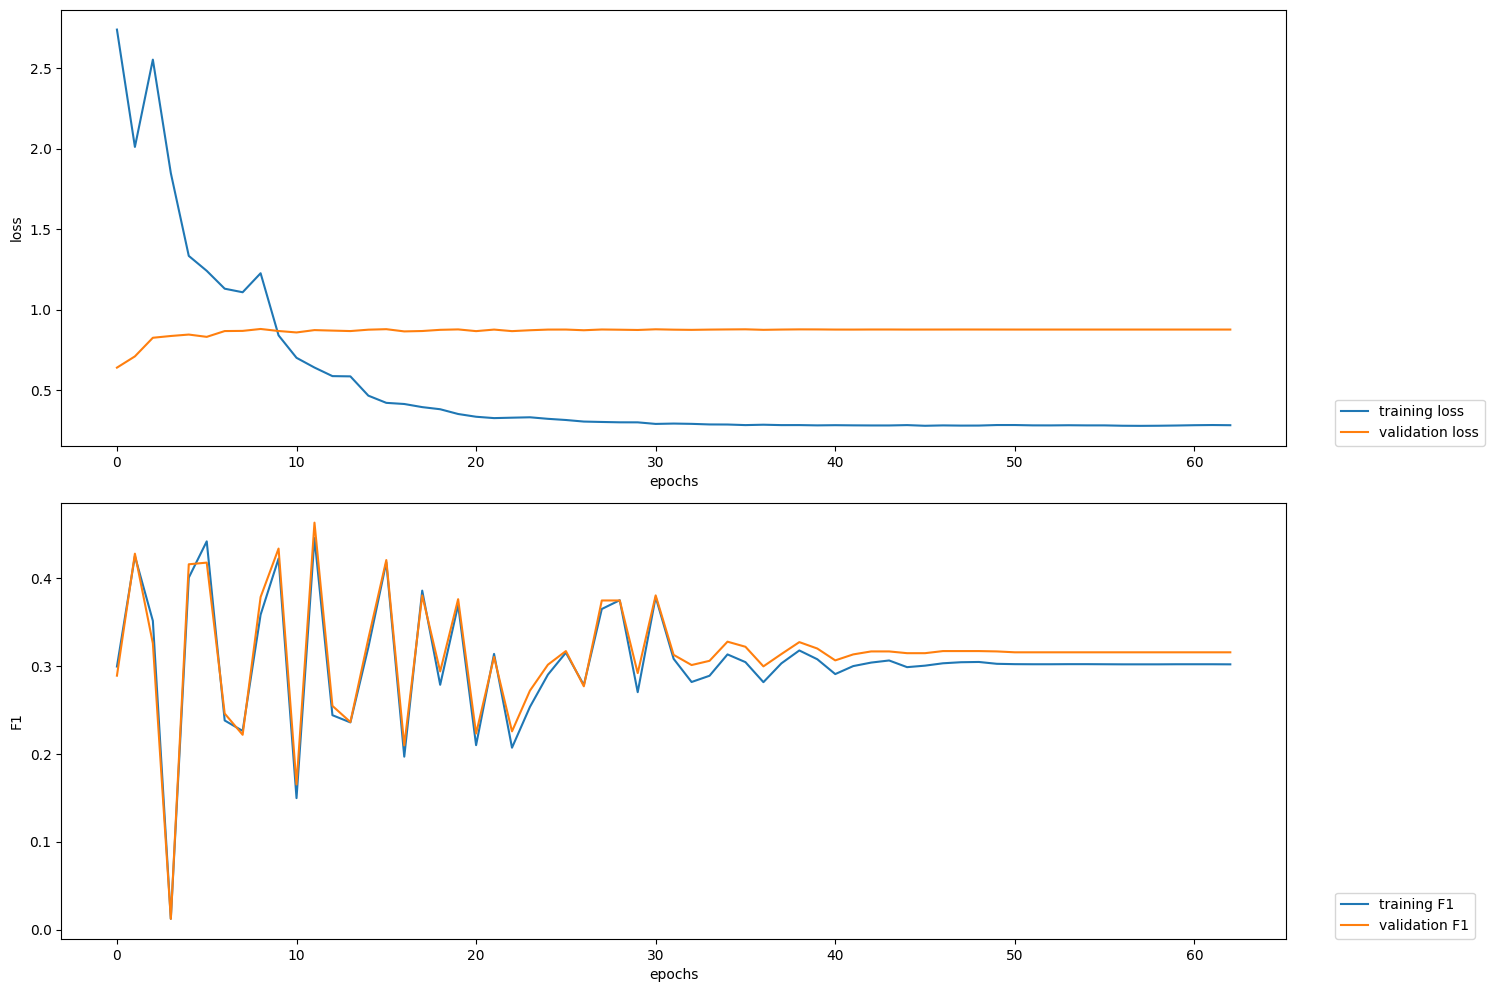

100%|██████████| 79/79 [00:32<00:00,  2.41it/s]

2023-04-21 02:29:12,345 Evaluating as a multi-label problem: True



100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

2023-04-21 02:29:19,520 Evaluating as a multi-label problem: False



100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

2023-04-21 02:29:24,002 Evaluating as a multi-label problem: True


,split,index,I-ADR,B-ADR,B-Drug,I-Finding,B-Finding,B-Disease,B-Symptom,I-Symptom,I-Disease,I-Drug,micro avg,macro avg,weighted avg,samples avg
0,train,precision,0.563650,0.653068,0.992108,0.0,0.0,0.166667,0.222222,0.0,0.166667,1.000000,0.631702,0.376438,0.586638,0.062784
1,train,recall,0.385263,0.424660,0.630372,0.0,0.0,0.004329,0.009009,0.0,0.005917,0.006211,0.378499,0.146576,0.378499,0.062752
2,train,f1-score,0.457689,0.514660,0.770915,0.0,0.0,0.008439,0.017316,0.0,0.011429,0.012346,0.473368,0.179279,0.454898,0.062762
3,train,support,7953.000000,4712.000000,1396.000000,349.0,309.0,231.000000,222.000000,218.0,169.000000,161.000000,15720.000000,15720.000000,15720.000000,15720.000000
0,dev,precision,0.484076,0.664234,0.992537,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.589205,0.214085,0.524037,NaN
1,dev,recall,0.393375,0.419355,0.722826,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.380445,0.153556,0.380445,NaN
2,dev,f1-score,0.434038,0.514124,0.836478,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.462353,0.178464,0.439442,NaN
3,dev,support,966.000000,651.000000,184.000000,54.0,64.0,31.000000,25.000000,36.0,28.000000,27.000000,2066.000000,2066.000000,2066.000000,NaN
0,test,precision,0.549231,0.678474,0.992593,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.641248,0.222030,0.572793,0.062532
1,test,recall,0.369183,0.432292,0.611872,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.372046,0.141335,0.372046,0.062489


In [24]:
print(suf)

os.mkdir('flair_ner_model'+suf+'/classification_report')
plotter.plot_training_curves('flair_ner_model'+suf+'/loss.tsv')

# evaluate the tagger on the test set
result = tagger.evaluate(corpus.train, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=12,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/train.txt', 'w').write(str(result))
res1 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res1.insert(loc=0, column='split', value='train')

result = tagger.evaluate(corpus.dev, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=12,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/dev.txt', 'w').write(str(result))
res2 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res2.insert(loc=0, column='split', value='dev')

result = tagger.evaluate(corpus.test, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=12,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/test.txt', 'w').write(str(result))
res3 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res3.insert(loc=0, column='split', value='test')

res = pd.concat([res1,res2,res3],ignore_index=True)
res.to_csv('flair_ner_model'+suf+'/classification_report.csv',index=False)
res

In [18]:
# import time
# start_time = time.time()
# while time.time() - start_time < 1:
#     time.sleep(1)
# print('Session has timed out (2 minutes). Disconnecting...')
# !kill -9 -1

Layering can be a good idea if the NER tags in the first layer have their own set of dependent values in the second layer. This can help capture more information about the entities being recognized and provide more context for downstream tasks. However, it also increases the complexity of the annotation and the training process, so it should be used judiciously. In general, it's a good idea to start with a simple tag scheme and gradually increase complexity as needed.

    does it really matter if u use the E header

It depends on the specific task and the requirements of the downstream model. In some cases, using the E tag can help disambiguate between overlapping entities, while in other cases it may not be necessary or even desired. Ultimately, it's up to the developer to determine the appropriate tagging scheme for their specific use case.

    would adding POS as an extra NER layer help model performance or not

Adding POS as an extra NER layer may or may not help model performance, depending on the specific use case and data being analyzed.

On one hand, incorporating POS tags could provide additional context to the model and help it better distinguish between named entities and other parts of speech. For example, knowing that a word is a noun or verb could help the model determine if it is likely to be a named entity or not.

On the other hand, adding an additional layer could also increase model complexity and training time without necessarily improving performance. It may also require additional manual annotation efforts to create a labeled dataset with both NER and POS tags.

Ultimately, whether to include POS as an additional layer will depend on the specific requirements and goals of the project, as well as the available data and resources.

    besides bioes ordering (which is up-to-down), it doesn't matter what order the tags in the same domain appear in left-to-right?

Yes, that is correct. As long as the BIOES order is maintained vertically, the order of tags in the same domain from left-to-right should not impact training in flai

    different typenames must be treated as separate tasks?

Yes, that's correct. Different typenames should be treated as separate tasks because they represent different types of annotations that you want to predict. For example, in a biomedical NER task, you might want to predict the entity types of both drugs and diseases, which would be represented by two different typenames in your annotation data. Predicting both types of entities would require different models and possibly different evaluation metrics.